[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/husseinlopez/diplomadoIA/blob/main/M1-4_Ejercicios_Limpieza.ipynb)

# Módulo 1: Introducción a la Minería de Datos
## Ejercicios Prácticos de Limpieza y Preparación de Datos

**Diplomado en Inteligencia Artificial**  
Dr. Irvin Hussein López Nava  
CICESE - UABC

---

## Objetivos de esta sesión

1. **Identificar y corregir problemas de calidad** en conjuntos de datos reales
2. **Manejar valores faltantes** con diferentes estrategias de imputación
3. **Detectar y tratar valores atípicos** sin perder información relevante
4. **Aplicar técnicas de reducción de dimensionalidad** (PCA, t-SNE)
5. **Seleccionar atributos relevantes** mediante métodos Filter y Wrapper
6. **Balancear clases desbalanceadas** con técnicas de over/undersampling

---

## Estructura del notebook

### Parte 1: Limpieza de Datos
* Inspección inicial y detección de problemas
* Manejo de valores faltantes
* Identificación y tratamiento de outliers
* Transformaciones y escalamiento

### Parte 2: Reducción de Dimensionalidad
* Análisis de Componentes Principales (PCA)
* t-SNE para visualización no lineal
* Comparación de métodos

### Parte 3: Selección de Atributos
* Métodos basados en filtros (Filter)
* Métodos Wrapper
* Consenso entre métodos

### Parte 4: Balanceo de Clases
* Técnicas de oversampling (SMOTE, ADASYN)
* Técnicas de undersampling
* Visualización del impacto

---
## 0. Configuración del Entorno

Importaremos todas las bibliotecas necesarias para el análisis completo.

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
from scipy import stats

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Reproducibilidad
np.random.seed(42)

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ Bibliotecas básicas importadas correctamente")

✓ Bibliotecas básicas importadas correctamente


In [2]:
# Preprocesamiento
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    LabelEncoder, OneHotEncoder, PowerTransformer
)
from sklearn.impute import SimpleImputer, KNNImputer

# Reducción de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Selección de atributos
from sklearn.feature_selection import (
    SelectKBest, chi2, f_classif, mutual_info_classif,
    RFE
)

# Modelos para selección
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Balanceo de clases
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Datasets
from sklearn.datasets import load_breast_cancer, make_classification

print("✓ Bibliotecas de ML y preprocesamiento importadas correctamente")

✓ Bibliotecas de ML y preprocesamiento importadas correctamente


---
# Parte 1: Limpieza de Datos

En esta sección trabajaremos con un dataset que presenta problemas comunes:
- Valores faltantes
- Valores atípicos
- Escalas incompatibles
- Tipos de datos incorrectos

## 1.1 Creación de un Dataset con Problemas Reales

Crearemos un dataset sintético que simula datos médicos con problemas típicos.

In [3]:
def create_messy_health_dataset(n_samples=500):
    """
    Crea un dataset sintético de datos de salud con problemas reales:
    - Valores faltantes (MCAR, MAR, MNAR)
    - Outliers
    - Escalas inconsistentes
    - Errores de registro
    """
    np.random.seed(42)

    # Variables base
    data = {
        'edad': np.random.normal(45, 15, n_samples).clip(18, 90),
        'peso': np.random.normal(70, 15, n_samples).clip(40, 150),
        'estatura': np.random.normal(165, 10, n_samples).clip(140, 200),
        'presion_sistolica': np.random.normal(120, 15, n_samples).clip(80, 200),
        'presion_diastolica': np.random.normal(80, 10, n_samples).clip(60, 120),
        'glucosa': np.random.normal(100, 20, n_samples).clip(70, 300),
        'colesterol': np.random.normal(200, 40, n_samples).clip(120, 350),
        'trigliceridos': np.random.normal(150, 50, n_samples).clip(50, 500),
        'frecuencia_cardiaca': np.random.normal(75, 10, n_samples).clip(50, 120),
    }

    df = pd.DataFrame(data)

    # Calcular IMC
    df['imc'] = df['peso'] / ((df['estatura']/100) ** 2)

    # Variables categóricas
    df['genero'] = np.random.choice(['M', 'F'], n_samples)
    df['fumador'] = np.random.choice(['Si', 'No', 'Exfumador'], n_samples, p=[0.2, 0.6, 0.2])
    df['diabetes'] = (df['glucosa'] > 126).astype(int)
    df['hipertension'] = (df['presion_sistolica'] > 140).astype(int)

    # Introducir valores faltantes de diferentes tipos

    # MCAR (Missing Completely At Random) - 5% en edad
    mcar_mask = np.random.random(n_samples) < 0.05
    df.loc[mcar_mask, 'edad'] = np.nan

    # MAR (Missing At Random) - Personas con diabetes tienen más faltantes en colesterol
    mar_mask = (df['diabetes'] == 1) & (np.random.random(n_samples) < 0.15)
    df.loc[mar_mask, 'colesterol'] = np.nan

    # MNAR (Missing Not At Random) - Valores altos de glucosa tienden a faltar más
    high_glucose = df['glucosa'] > df['glucosa'].quantile(0.75)
    mnar_mask = high_glucose & (np.random.random(n_samples) < 0.10)
    df.loc[mnar_mask, 'glucosa'] = np.nan

    # Valores faltantes adicionales
    df.loc[np.random.random(n_samples) < 0.08, 'trigliceridos'] = np.nan
    df.loc[np.random.random(n_samples) < 0.03, 'frecuencia_cardiaca'] = np.nan

    # Introducir outliers

    # Outliers extremos (errores de medición)
    outlier_indices = np.random.choice(n_samples, size=10, replace=False)
    df.loc[outlier_indices[:3], 'peso'] = np.random.uniform(200, 250, 3)
    df.loc[outlier_indices[3:6], 'presion_sistolica'] = np.random.uniform(220, 280, 3)
    df.loc[outlier_indices[6:], 'glucosa'] = np.random.uniform(400, 600, 4)

    # Outliers moderados (valores reales pero inusuales)
    moderate_outliers = np.random.choice(n_samples, size=20, replace=False)
    df.loc[moderate_outliers, 'colesterol'] = np.random.uniform(300, 400, 20)

    # Introducir inconsistencias

    # Algunas estatura en cm, otras (pocas) en metros
    error_indices = np.random.choice(n_samples, size=5, replace=False)
    df.loc[error_indices, 'estatura'] = df.loc[error_indices, 'estatura'] / 100

    # Calcular variable objetivo (riesgo cardiovascular)
    risk_score = (
        (df['edad'] > 55).astype(int) * 2 +
        (df['imc'] > 30).astype(int) * 2 +
        df['diabetes'] * 3 +
        df['hipertension'] * 3 +
        (df['fumador'] == 'Si').astype(int) * 2 +
        (df['colesterol'] > 240).fillna(0).astype(int) * 2
    )

    # Binarizar riesgo con algo de ruido
    noise = np.random.random(n_samples) < 0.1
    df['riesgo_alto'] = ((risk_score >= 6) != noise).astype(int)

    return df

# Crear dataset
df_health = create_messy_health_dataset(500)

print(f"Dataset creado con {len(df_health)} observaciones y {len(df_health.columns)} variables")
print(f"\nPrimeras filas:")
df_health.head(10)

Dataset creado con 500 observaciones y 15 variables

Primeras filas:


edad   peso  estatura  presion_sistolica  presion_diastolica  glucosa  \
0 52.451 83.893   178.994            131.675              73.248  111.412   
1 42.926 98.641   174.246            111.732              78.555  119.364   
2 54.715 49.021   165.596            107.727              72.076   93.374   
3 67.845 78.445   158.531            119.949              76.920   87.755   
4 41.488 60.240   171.982            117.447              61.064   78.297   
5 41.488 62.693   168.935            113.202              82.133   83.492   
6 68.688 61.114   173.952            130.446              80.012  158.982   
7 56.512 57.040   171.352            134.330              71.829  124.894   
8 37.958 70.728   175.496            121.326              86.592   72.979   
9 53.138 57.536   159.648            142.163              89.376   73.551   

   colesterol  trigliceridos  frecuencia_cardiaca    imc genero    fumador  \
0     123.688        209.032               66.365 26.185      F         No   
1     165.585        118.634               74.688 32.489      M  Exfumador   
2     183.456        152.261               75.180 17.877      F         Si   
3     275.508            NaN               79.726 31.213      F         Si   
4     222.262        124.911               61.331 20.367      M         No   
5     146.581            NaN               80.926 21.968      M         No   
6     219.441        166.149               50.000 20.197      F         Si   
7     138.108        146.950               68.701 19.427      F         No   
8     243.308        175.012               70.117 22.965      M         No   
9     181.155        123.320               81.333 22.574      M         No   

   diabetes  hipertension  riesgo_alto  
0         0             0            0  
1         0             0            0  
2         0             0            1  
3         0             0            1  
4         0             0            0  
5         0             0            0  
6         1             0            1  
7         0             0            0  
8         0             0            0  
9         0             1            0

## 1.2 Inspección Inicial

Primer vistazo a la estructura y calidad de los datos.

In [4]:
def inspect_dataset(df):
    """
    Realiza una inspección completa del dataset
    """
    print("="*80)
    print("INSPECCIÓN GENERAL DEL DATASET")
    print("="*80)

    print(f"\n📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
    print(f"💾 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print("\n" + "="*80)
    print("TIPOS DE DATOS")
    print("="*80)
    print(df.dtypes)

    print("\n" + "="*80)
    print("VALORES FALTANTES")
    print("="*80)

    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    missing_table = pd.DataFrame({
        'Columna': missing.index,
        'Faltantes': missing.values,
        'Porcentaje': missing_pct.values
    })
    missing_table = missing_table[missing_table['Faltantes'] > 0].sort_values('Porcentaje', ascending=False)

    if len(missing_table) > 0:
        print(missing_table.to_string(index=False))
        print(f"\n⚠️  Total de valores faltantes: {missing.sum()} ({100*missing.sum()/(df.shape[0]*df.shape[1]):.2f}% del dataset)")
    else:
        print("✓ No hay valores faltantes")

    print("\n" + "="*80)
    print("ESTADÍSTICAS DESCRIPTIVAS (VARIABLES NUMÉRICAS)")
    print("="*80)
    print(df.describe().T)

    print("\n" + "="*80)
    print("DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS")
    print("="*80)

    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())
        print(f"Valores únicos: {df[col].nunique()}")

inspect_dataset(df_health)

INSPECCIÓN GENERAL DEL DATASET

📊 Dimensiones: 500 filas × 15 columnas
💾 Memoria utilizada: 0.10 MB

TIPOS DE DATOS
edad                   float64
peso                   float64
estatura               float64
presion_sistolica      float64
presion_diastolica     float64
glucosa                float64
colesterol             float64
trigliceridos          float64
frecuencia_cardiaca    float64
imc                    float64
genero                  object
fumador                 object
diabetes                 int64
hipertension             int64
riesgo_alto              int64
dtype: object

VALORES FALTANTES
            Columna  Faltantes  Porcentaje
      trigliceridos         42       8.400
               edad         20       4.000
frecuencia_cardiaca         16       3.200
            glucosa         14       2.800
         colesterol          2       0.400

⚠️  Total de valores faltantes: 94 (1.25% del dataset)

ESTADÍSTICAS DESCRIPTIVAS (VARIABLES NUMÉRICAS)
                      c

## 1.3 Visualización de Valores Faltantes

Entender el patrón de datos faltantes es crucial para decidir cómo manejarlos.

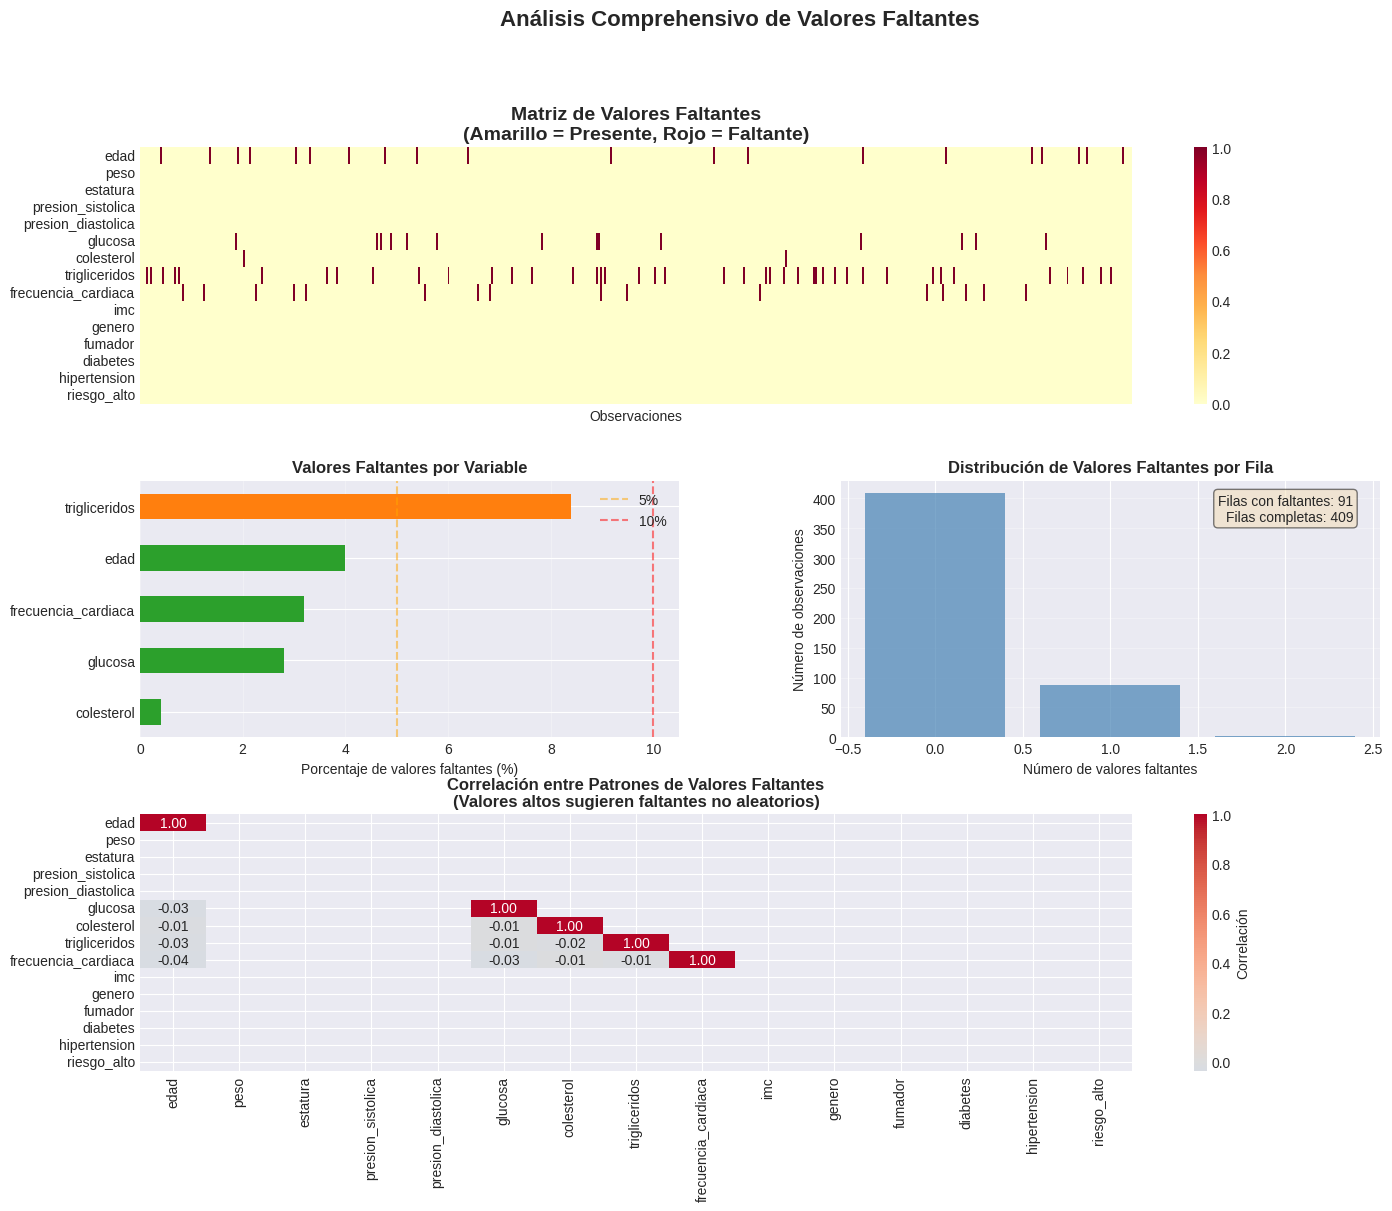

In [5]:
def visualize_missing_data(df):
    """
    Crea visualizaciones comprehensivas de valores faltantes
    """
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # 1. Matriz de valores faltantes
    ax1 = fig.add_subplot(gs[0, :])
    missing_matrix = df.isnull().astype(int)
    sns.heatmap(missing_matrix.T, cmap='YlOrRd', cbar=True, ax=ax1,
                yticklabels=df.columns, xticklabels=False)
    ax1.set_title('Matriz de Valores Faltantes\n(Amarillo = Presente, Rojo = Faltante)',
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('Observaciones')

    # 2. Porcentaje de valores faltantes por columna
    ax2 = fig.add_subplot(gs[1, 0])
    missing_pct = 100 * df.isnull().sum() / len(df)
    missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=True)

    if len(missing_pct) > 0:
        colors = ['#d62728' if x > 10 else '#ff7f0e' if x > 5 else '#2ca02c' for x in missing_pct]
        missing_pct.plot(kind='barh', ax=ax2, color=colors)
        ax2.set_xlabel('Porcentaje de valores faltantes (%)')
        ax2.set_title('Valores Faltantes por Variable', fontweight='bold')
        ax2.axvline(x=5, color='orange', linestyle='--', alpha=0.5, label='5%')
        ax2.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='10%')
        ax2.legend()
        ax2.grid(axis='x', alpha=0.3)

    # 3. Número de valores faltantes por fila
    ax3 = fig.add_subplot(gs[1, 1])
    missing_per_row = df.isnull().sum(axis=1)
    missing_counts = missing_per_row.value_counts().sort_index()

    ax3.bar(missing_counts.index, missing_counts.values, color='steelblue', alpha=0.7)
    ax3.set_xlabel('Número de valores faltantes')
    ax3.set_ylabel('Número de observaciones')
    ax3.set_title('Distribución de Valores Faltantes por Fila', fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    # Añadir texto con estadísticas
    total_rows_with_missing = (missing_per_row > 0).sum()
    ax3.text(0.95, 0.95,
             f'Filas con faltantes: {total_rows_with_missing}\n'
             f'Filas completas: {len(df) - total_rows_with_missing}',
             transform=ax3.transAxes, fontsize=10,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 4. Correlación entre valores faltantes
    ax4 = fig.add_subplot(gs[2, :])
    missing_corr = df.isnull().corr()
    mask = np.triu(np.ones_like(missing_corr), k=1)

    sns.heatmap(missing_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=ax4, cbar_kws={'label': 'Correlación'})
    ax4.set_title('Correlación entre Patrones de Valores Faltantes\n'
                  '(Valores altos sugieren faltantes no aleatorios)', fontweight='bold')

    plt.suptitle('Análisis Comprehensivo de Valores Faltantes',
                 fontsize=16, fontweight='bold', y=0.995)

    return fig

fig = visualize_missing_data(df_health)
plt.show()

## 1.4 Análisis de Patrones de Valores Faltantes

Determinar si los valores faltantes son MCAR, MAR o MNAR.

In [6]:
# Análisis detallado de patrones de valores faltantes
def analyze_missing_patterns(df):
    """
    Analiza si los valores faltantes son MCAR, MAR o MNAR
    """
    print("="*80)
    print("ANÁLISIS DE PATRONES DE VALORES FALTANTES")
    print("="*80)

    # Crear indicadores de faltantes
    cols_with_missing = df.columns[df.isnull().any()].tolist()

    for col in cols_with_missing:
        print(f"\n{'='*80}")
        print(f"Variable: {col}")
        print(f"{'='*80}")

        missing_mask = df[col].isnull()

        # Comparar características entre observaciones con y sin faltantes
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        numeric_cols = [c for c in numeric_cols if c != col]

        print("\nComparación de medias (con faltantes vs sin faltantes):")
        print("-" * 60)

        for other_col in numeric_cols[:5]:  # Limitamos a 5 para no saturar
            if df[other_col].notna().sum() > 0:
                mean_missing = df.loc[missing_mask, other_col].mean()
                mean_present = df.loc[~missing_mask, other_col].mean()

                if pd.notna(mean_missing) and pd.notna(mean_present):
                    diff_pct = 100 * (mean_missing - mean_present) / mean_present

                    # Test t para diferencia de medias
                    try:
                        t_stat, p_value = stats.ttest_ind(
                            df.loc[missing_mask, other_col].dropna(),
                            df.loc[~missing_mask, other_col].dropna()
                        )
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                    except:
                        p_value = np.nan
                        significance = ""

                    print(f"{other_col:30s}: {mean_present:7.2f} → {mean_missing:7.2f} "
                          f"({diff_pct:+6.1f}%) p={p_value:.3f} {significance}")

    print("\n" + "="*80)
    print("INTERPRETACIÓN:")
    print("="*80)
    print("* = p < 0.05  (diferencia estadísticamente significativa)")
    print("** = p < 0.01 (alta significancia)")
    print("*** = p < 0.001 (muy alta significancia)")
    print("\nDiferencias significativas sugieren valores faltantes MAR o MNAR")
    print("No diferencias sugiere MCAR (Missing Completely At Random)")

analyze_missing_patterns(df_health)

ANÁLISIS DE PATRONES DE VALORES FALTANTES

Variable: edad

Comparación de medias (con faltantes vs sin faltantes):
------------------------------------------------------------
peso                          :   71.75 →   66.18 (  -7.8%) p=0.190 
estatura                      :  164.28 →  168.31 (  +2.5%) p=0.358 
presion_sistolica             :  121.41 →  118.46 (  -2.4%) p=0.454 
presion_diastolica            :   79.99 →   79.02 (  -1.2%) p=0.654 
glucosa                       :  103.76 →  101.93 (  -1.8%) p=0.846 

Variable: glucosa

Comparación de medias (con faltantes vs sin faltantes):
------------------------------------------------------------
edad                          :   45.36 →   44.71 (  -1.4%) p=0.867 
peso                          :   71.52 →   71.98 (  +0.7%) p=0.926 
estatura                      :  164.38 →  166.33 (  +1.2%) p=0.708 
presion_sistolica             :  121.41 →  117.30 (  -3.4%) p=0.381 
presion_diastolica            :   79.91 →   81.34 (  +1.8%) p=0.57

## 1.4 Manejo de Valores Faltantes

Compararemos diferentes estrategias de imputación.

In [7]:
def compare_imputation_methods(df, column):
    """
    Compara diferentes métodos de imputación en una columna específica
    """
    df_test = df.copy()
    missing_mask = df_test[column].isnull()
    original_values = df_test.loc[~missing_mask, column].copy()

    methods = {}

    # 1. Eliminación
    methods['Eliminación'] = df_test[column].dropna()

    # 2. Media
    imputer_mean = SimpleImputer(strategy='mean')
    methods['Media'] = pd.Series(
        imputer_mean.fit_transform(df_test[[column]]).ravel(),
        index=df_test.index
    )

    # 3. Mediana
    imputer_median = SimpleImputer(strategy='median')
    methods['Mediana'] = pd.Series(
        imputer_median.fit_transform(df_test[[column]]).ravel(),
        index=df_test.index
    )

    # 4. KNN Imputer
    numeric_cols = df_test.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) > 1:
        imputer_knn = KNNImputer(n_neighbors=5)
        df_knn = df_test[numeric_cols].copy()
        imputed_knn = imputer_knn.fit_transform(df_knn)
        col_idx = numeric_cols.index(column)
        methods['KNN (k=5)'] = pd.Series(
            imputed_knn[:, col_idx],
            index=df_test.index
        )

    # Visualización comparativa
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()

    # Plot original
    ax = axes[0]
    ax.hist(original_values, bins=30, alpha=0.7, color='gray', edgecolor='black')
    ax.axvline(original_values.mean(), color='red', linestyle='--',
               linewidth=2, label=f'Media: {original_values.mean():.2f}')
    ax.axvline(original_values.median(), color='blue', linestyle='--',
               linewidth=2, label=f'Mediana: {original_values.median():.2f}')
    ax.set_title('Distribución Original\\n(sin valores faltantes)', fontweight='bold')
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')
    ax.legend()
    ax.grid(alpha=0.3)

    # Plot cada método
    for idx, (method_name, imputed_data) in enumerate(methods.items(), 1):
        if idx >= len(axes):
            break
        ax = axes[idx]
        ax.hist(original_values, bins=30, alpha=0.4, color='gray', label='Original', edgecolor='black')
        ax.hist(imputed_data.dropna(), bins=30, alpha=0.6, color='steelblue', label=method_name, edgecolor='black')
        mean_diff = imputed_data.mean() - original_values.mean()
        std_diff = imputed_data.std() - original_values.std()
        ax.set_title(f'{method_name}\\nΔmedia: {mean_diff:+.2f}, Δstd: {std_diff:+.2f}', fontweight='bold')
        ax.set_xlabel(column)
        ax.set_ylabel('Frecuencia')
        ax.legend()
        ax.grid(alpha=0.3)

    for idx in range(len(methods) + 1, len(axes)):
        axes[idx].axis('off')

    plt.suptitle(f'Comparación de Métodos de Imputación: {column}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Estadísticas
    print("="*80)
    print(f"COMPARACIÓN DE MÉTODOS DE IMPUTACIÓN: {column}")
    print("="*80)
    print(f"\\nOriginal: N={len(original_values)}, Media={original_values.mean():.2f}, Std={original_values.std():.2f}")
    for method_name, imputed_data in methods.items():
        print(f"{method_name}: N={len(imputed_data.dropna())}, Media={imputed_data.mean():.2f}, Std={imputed_data.std():.2f}")

    return fig, methods

# Comparar métodos para glucosa
fig, methods = compare_imputation_methods(df_health, 'glucosa')
plt.show()

COMPARACIÓN DE MÉTODOS DE IMPUTACIÓN: glucosa
\nOriginal: N=486, Media=103.68, Std=41.11
Eliminación: N=486, Media=103.68, Std=41.11
Media: N=500, Media=103.68, Std=40.52
Mediana: N=500, Media=103.56, Std=40.53
KNN (k=5): N=500, Media=103.83, Std=40.77


In [8]:
# Aplicar imputación con KNN
def apply_imputation(df, strategy='knn'):
    """
    Aplica estrategia de imputación al dataset completo
    """
    df_imputed = df.copy()

    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns.tolist()

    if strategy == 'knn':
        imputer_num = KNNImputer(n_neighbors=5)
        df_imputed[numeric_cols] = imputer_num.fit_transform(df_imputed[numeric_cols])

        for col in categorical_cols:
            if df_imputed[col].isnull().any():
                mode_value = df_imputed[col].mode()[0]
                df_imputed[col].fillna(mode_value, inplace=True)

    print(f"Imputación aplicada con estrategia: {strategy}")
    print(f"Filas antes: {len(df)} → Filas después: {len(df_imputed)}")
    print(f"Valores faltantes restantes: {df_imputed.isnull().sum().sum()}")

    return df_imputed

df_health_imputed = apply_imputation(df_health, strategy='knn')

Imputación aplicada con estrategia: knn
Filas antes: 500 → Filas después: 500
Valores faltantes restantes: 0


## 1.5 Detección y Tratamiento de Outliers

Identificaremos valores atípicos usando múltiples métodos.

DETECCIÓN DE OUTLIERS: peso

Total observaciones válidas: 500
IQR                 :    6 ( 1.20%)
Z-score             :    3 ( 0.60%)
Isolation Forest    :   50 (10.00%)

Consenso (≥2 métodos): 6 (1.20%)


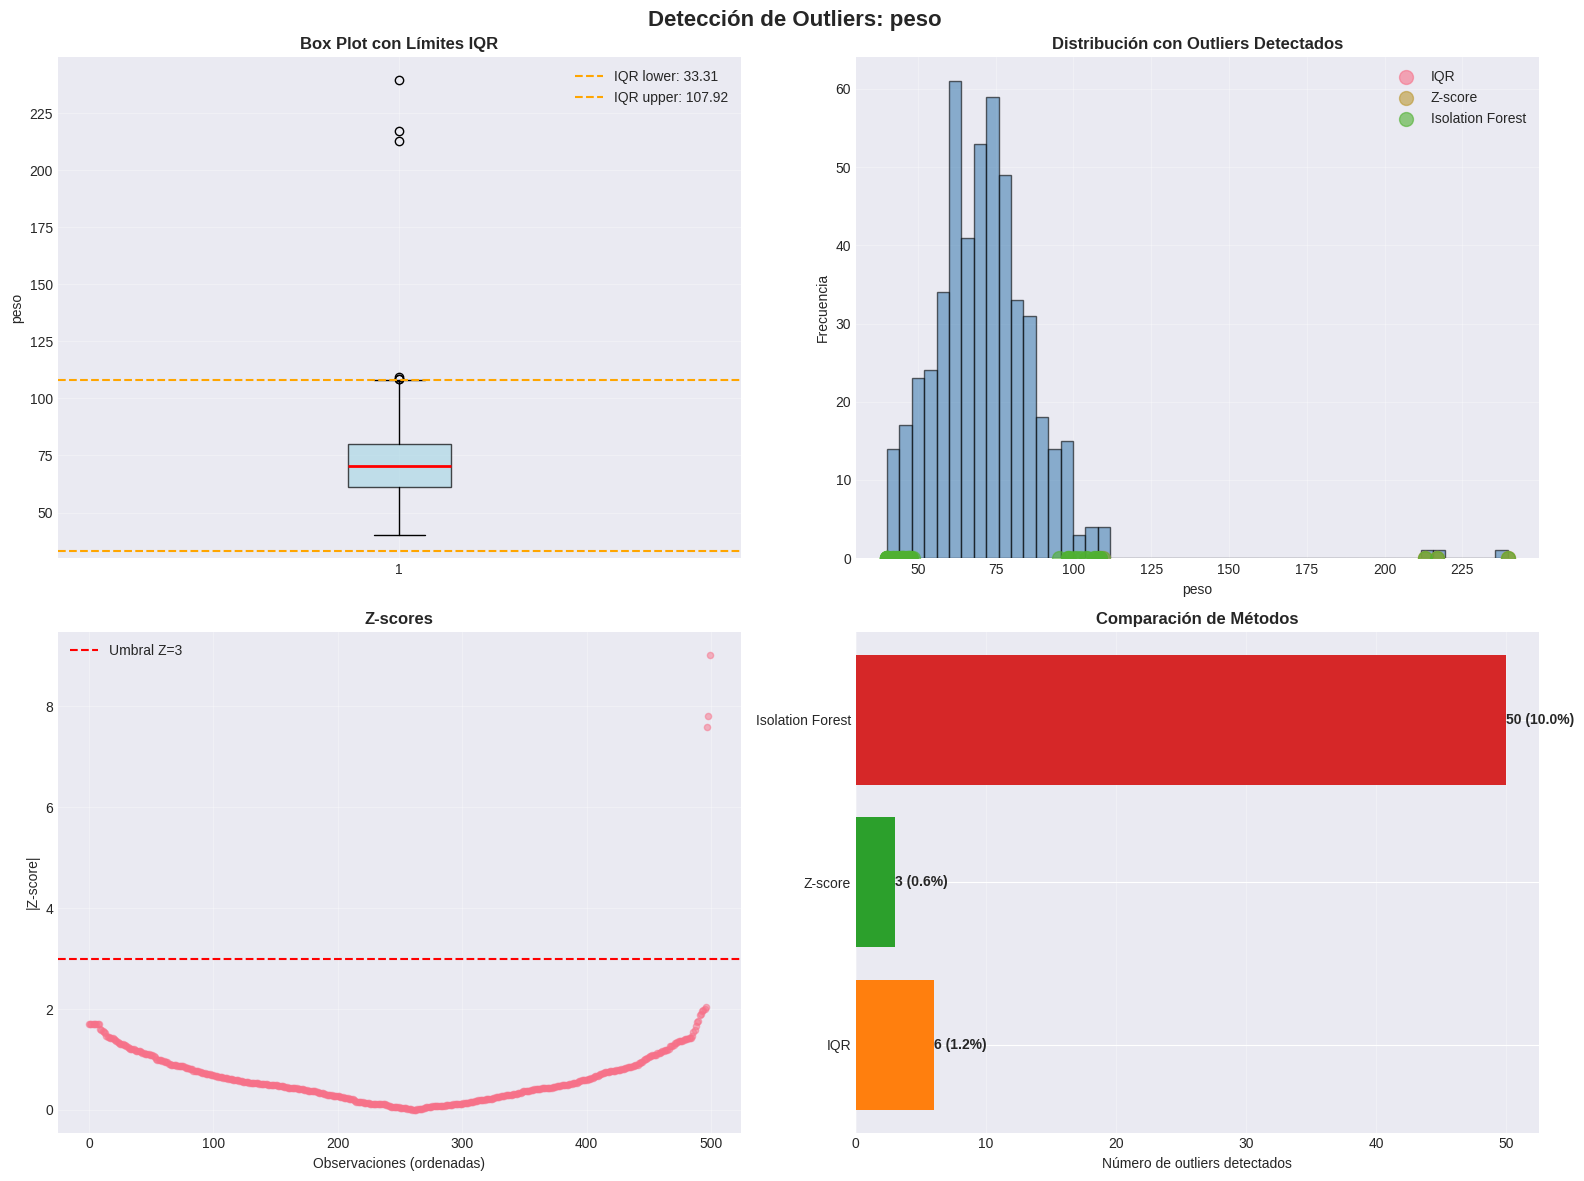

In [9]:
def detect_outliers_multiple_methods(df, column):
    """
    Detecta outliers usando diferentes métodos:
    1. IQR (Interquartile Range)
    2. Z-score
    3. Isolation Forest
    """
    from sklearn.ensemble import IsolationForest

    # Trabajar solo con datos no nulos
    data = df[column].dropna().values.reshape(-1, 1)

    outliers = {}

    # 1. Método IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers['IQR'] = (data < lower_bound) | (data > upper_bound)

    # 2. Z-score
    z_scores = np.abs(stats.zscore(data))
    outliers['Z-score'] = z_scores > 3

    # 3. Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers['Isolation Forest'] = iso_forest.fit_predict(data) == -1

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Box plot
    ax = axes[0, 0]
    bp = ax.boxplot([data.ravel()], vert=True, patch_artist=True,
                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                     medianprops=dict(color='red', linewidth=2))
    ax.axhline(lower_bound, color='orange', linestyle='--', label=f'IQR lower: {lower_bound:.2f}')
    ax.axhline(upper_bound, color='orange', linestyle='--', label=f'IQR upper: {upper_bound:.2f}')
    ax.set_ylabel(column)
    ax.set_title('Box Plot con Límites IQR', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # Distribución con outliers
    ax = axes[0, 1]
    ax.hist(data, bins=50, alpha=0.6, color='steelblue', edgecolor='black')
    for method_name, is_outlier in outliers.items():
        outlier_values = data[is_outlier.ravel()]
        if len(outlier_values) > 0:
            ax.scatter(outlier_values, [0] * len(outlier_values), s=100, alpha=0.6, label=method_name)
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')
    ax.set_title('Distribución con Outliers Detectados', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # Z-scores
    ax = axes[1, 0]
    sorted_idx = np.argsort(data.ravel())
    ax.scatter(range(len(data)), z_scores[sorted_idx], alpha=0.5, s=20)
    ax.axhline(3, color='red', linestyle='--', label='Umbral Z=3')
    ax.set_xlabel('Observaciones (ordenadas)')
    ax.set_ylabel('|Z-score|')
    ax.set_title('Z-scores', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

    # Comparación
    ax = axes[1, 1]
    method_names = list(outliers.keys())
    counts = [outliers[m].sum() for m in method_names]
    bars = ax.barh(method_names, counts, color=['#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_xlabel('Número de outliers detectados')
    ax.set_title('Comparación de Métodos', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    for bar, count in zip(bars, counts):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
               f'{int(count)} ({100*count/len(data):.1f}%)',
               ha='left', va='center', fontweight='bold')

    plt.suptitle(f'Detección de Outliers: {column}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Consenso: contar cuántos métodos detectan cada punto como outlier
    consensus_votes = np.zeros(len(data), dtype=int)
    for method_array in outliers.values():
        consensus_votes += method_array.ravel().astype(int)

    # Crear máscara: True para outliers detectados por ≥2 métodos
    consensus_mask = pd.Series(False, index=df.index)

    # Obtener índices originales de los datos no nulos
    valid_indices = df[column].dropna().index

    # Identificar cuáles son outliers (≥2 métodos)
    is_outlier = consensus_votes >= 2

    # Marcar esos índices en la máscara
    consensus_mask[valid_indices[is_outlier]] = True

    print("="*80)
    print(f"DETECCIÓN DE OUTLIERS: {column}")
    print("="*80)
    print(f"\nTotal observaciones válidas: {len(data)}")
    for method, is_outlier_array in outliers.items():
        n_outliers = is_outlier_array.sum()
        print(f"{method:20s}: {n_outliers:4d} ({100*n_outliers/len(data):5.2f}%)")
    print(f"\nConsenso (≥2 métodos): {is_outlier.sum()} ({100*is_outlier.sum()/len(data):.2f}%)")

    return fig, outliers, consensus_mask

# Detectar outliers
fig_out, outliers_peso, consensus_peso = detect_outliers_multiple_methods(df_health_imputed, 'peso')
plt.show()


EJEMPLO 1: Método 'cap' (limitar valores)
Tratando 6 outliers en 'peso' usando método 'cap'
  → Valores limitados a [47.09, 96.92]


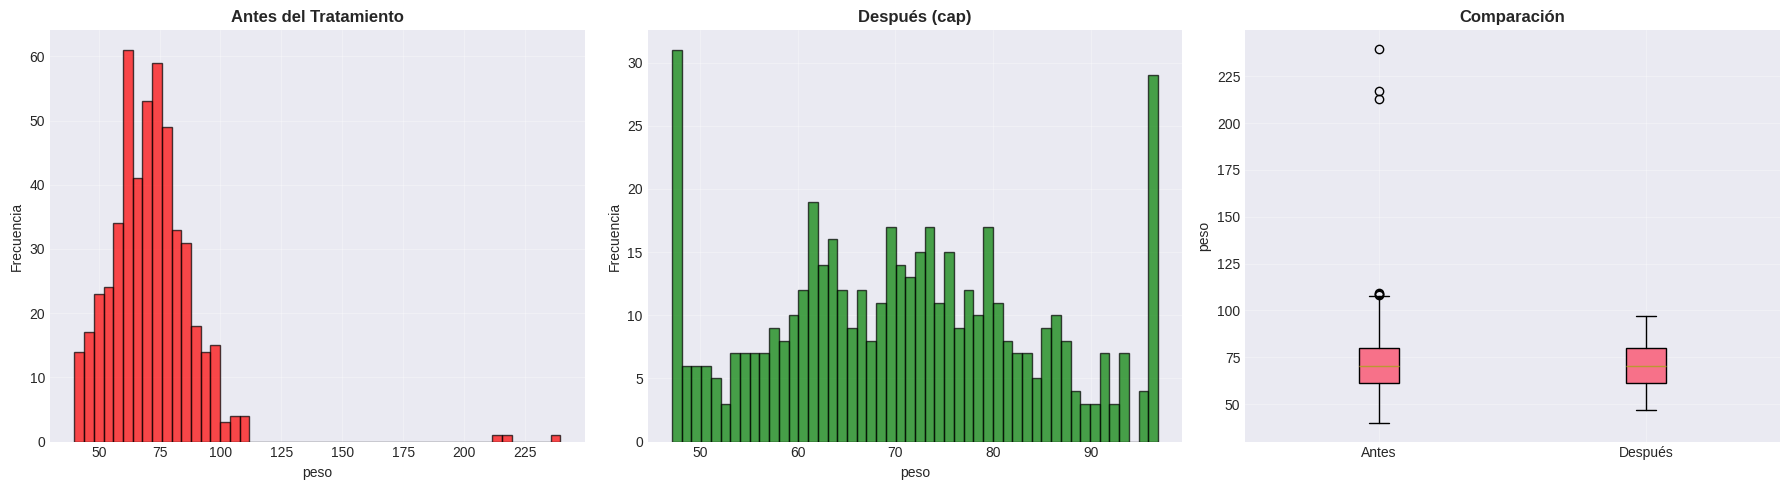


EJEMPLO 2: Método 'remove' (eliminar filas)
Tratando 6 outliers en 'peso' usando método 'remove'
  → Filas eliminadas: 6
  → Filas restantes: 494


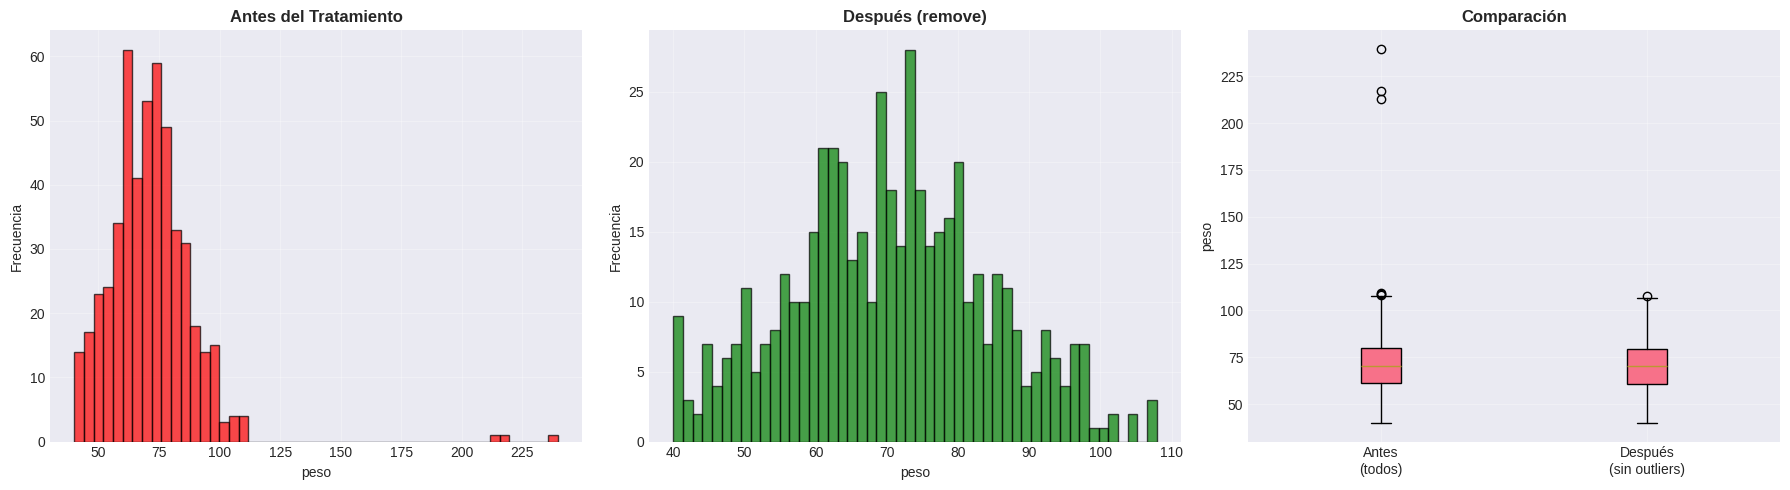

In [10]:
# Tratamiento de outliers
def treat_outliers(df, column, method='cap', outlier_mask=None):
    """
    Trata outliers usando diferentes estrategias

    Parameters:
    -----------
    df : DataFrame
        DataFrame con los datos
    column : str
        Nombre de la columna a tratar
    method : str
        Método de tratamiento: 'remove', 'cap', 'transform'
    outlier_mask : Series booleana
        Máscara indicando outliers (mismo índice que df)
    """
    df_treated = df.copy()
    original = df_treated[column].copy()

    if outlier_mask is None:
        # Si no hay máscara, usar IQR
        Q1 = df_treated[column].quantile(0.25)
        Q3 = df_treated[column].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_treated[column] < Q1 - 1.5*IQR) | (df_treated[column] > Q3 + 1.5*IQR)

    # Verificar que la máscara tenga el tamaño correcto
    if len(outlier_mask) != len(df_treated):
        raise ValueError(f"outlier_mask tiene tamaño {len(outlier_mask)} pero DataFrame tiene {len(df_treated)} filas")

    n_outliers = outlier_mask.sum()
    print(f"Tratando {n_outliers} outliers en '{column}' usando método '{method}'")

    if method == 'remove':
        df_treated = df_treated[~outlier_mask]
        print(f"  → Filas eliminadas: {n_outliers}")
        print(f"  → Filas restantes: {len(df_treated)}")
    elif method == 'cap':
        lower = df_treated[column].quantile(0.05)
        upper = df_treated[column].quantile(0.95)
        df_treated[column] = df_treated[column].clip(lower, upper)
        print(f"  → Valores limitados a [{lower:.2f}, {upper:.2f}]")
    elif method == 'transform':
        # Winsorización: reemplazar outliers con valores percentiles
        lower = df_treated[column].quantile(0.05)
        upper = df_treated[column].quantile(0.95)
        df_treated.loc[df_treated[column] < lower, column] = lower
        df_treated.loc[df_treated[column] > upper, column] = upper
        print(f"  → Outliers reemplazados con percentiles 5 y 95")

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Antes
    axes[0].hist(original.dropna(), bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0].set_title('Antes del Tratamiento', fontweight='bold')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frecuencia')
    axes[0].grid(alpha=0.3)

    # Después
    axes[1].hist(df_treated[column].dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title(f'Después ({method})', fontweight='bold')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('Frecuencia')
    axes[1].grid(alpha=0.3)

    # Comparación con boxplots
    if method != 'remove':
        axes[2].boxplot([original.dropna(), df_treated[column].dropna()],
                       labels=['Antes', 'Después'], patch_artist=True)
    else:
        # Para remove, solo mostrar el después
        axes[2].boxplot([original.dropna(), df_treated[column].dropna()],
                       labels=['Antes\n(todos)', 'Después\n(sin outliers)'], patch_artist=True)
    axes[2].set_title('Comparación', fontweight='bold')
    axes[2].set_ylabel(column)
    axes[2].grid(alpha=0.3)

    plt.tight_layout()

    return df_treated, fig

# Probar diferentes métodos
print("\n" + "="*80)
print("EJEMPLO 1: Método 'cap' (limitar valores)")
print("="*80)
df_peso_capped, fig_cap = treat_outliers(df_health_imputed, 'peso', method='cap', outlier_mask=consensus_peso)
plt.show()

print("\n" + "="*80)
print("EJEMPLO 2: Método 'remove' (eliminar filas)")
print("="*80)
df_peso_removed, fig_remove = treat_outliers(df_health_imputed, 'peso', method='remove', outlier_mask=consensus_peso)
plt.show()

---
# Parte 2: Reducción de Dimensionalidad

Aplicaremos PCA y t-SNE al dataset de salud que limpiamos previamente para visualizar su estructura.

## 2.1 Preparación del Dataset Limpio

Usaremos el dataset de salud después de la limpieza y escalamiento.

In [11]:
# Usar el dataset limpio y escalado
# Seleccionar solo variables numéricas
numeric_cols = df_health_imputed.select_dtypes(include=[np.number]).columns.tolist()

# Remover la variable objetivo
if 'riesgo_alto' in numeric_cols:
    numeric_cols.remove('riesgo_alto')

X_health = df_health_imputed[numeric_cols].copy()
y_health = df_health_imputed['riesgo_alto'].copy()

# Escalar datos
scaler = StandardScaler()
X_health_scaled = scaler.fit_transform(X_health)

print("="*80)
print("DATASET DE SALUD PREPARADO")
print("="*80)
print(f"\nDimensiones: {X_health.shape}")
print(f"Variables: {numeric_cols}")
print(f"\nDistribución de clases (riesgo_alto):")
print(y_health.value_counts())
print(f"\n✓ Datos escalados con StandardScaler")

DATASET DE SALUD PREPARADO

Dimensiones: (500, 12)
Variables: ['edad', 'peso', 'estatura', 'presion_sistolica', 'presion_diastolica', 'glucosa', 'colesterol', 'trigliceridos', 'frecuencia_cardiaca', 'imc', 'diabetes', 'hipertension']

Distribución de clases (riesgo_alto):
riesgo_alto
0.000    421
1.000     79
Name: count, dtype: int64

✓ Datos escalados con StandardScaler


## 2.2 Análisis de Componentes Principales (PCA)

PCA encuentra direcciones ortogonales de máxima varianza en los datos.

ANÁLISIS PCA

Dimensiones originales: 12

Componentes necesarios para:
  - 90% varianza: 10 componentes
  - 95% varianza: 11 componentes
  - 99% varianza: 12 componentes

Primeros 2 componentes explican: 26.8%
Primeros 3 componentes explican: 37.7%


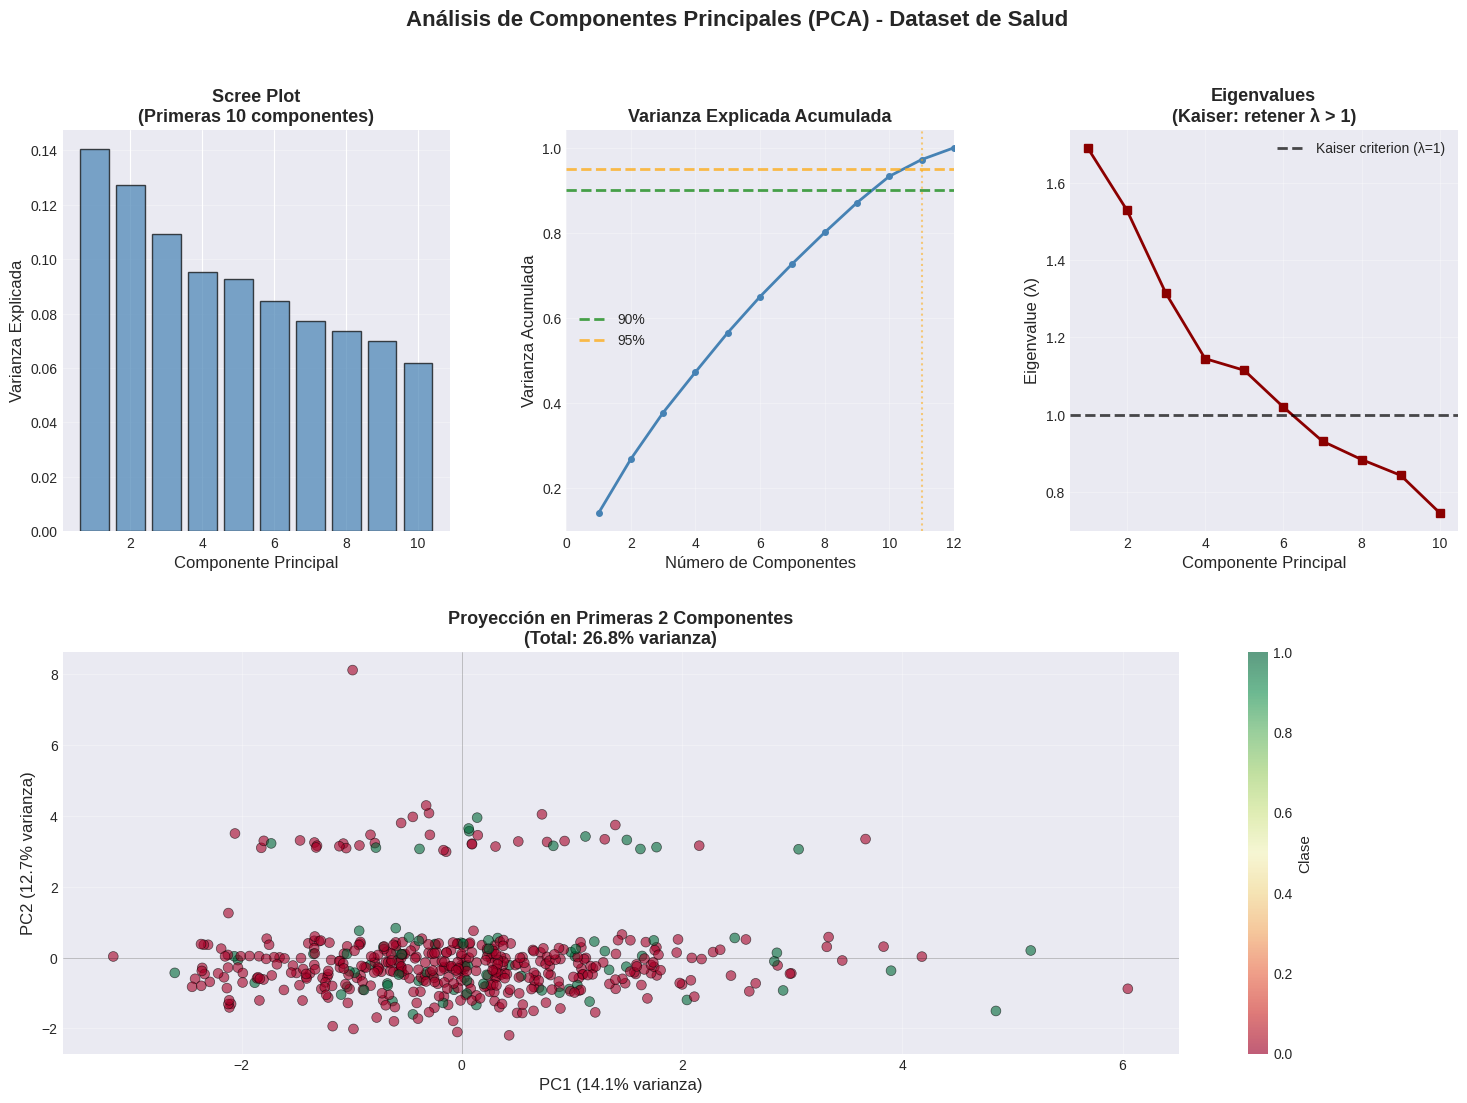

In [12]:
def perform_pca_analysis(X, y=None, feature_names=None):
    """
    Realiza análisis completo de PCA con múltiples visualizaciones
    """
    # PCA completo
    pca_full = PCA()
    X_pca_full = pca_full.fit_transform(X)

    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Encontrar componentes para 90%, 95%, 99%
    n_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_95 = np.argmax(cumulative_variance >= 0.95) + 1
    n_99 = np.argmax(cumulative_variance >= 0.99) + 1

    print("="*80)
    print("ANÁLISIS PCA")
    print("="*80)
    print(f"\nDimensiones originales: {X.shape[1]}")
    print(f"\nComponentes necesarios para:")
    print(f"  - 90% varianza: {n_90} componentes")
    print(f"  - 95% varianza: {n_95} componentes")
    print(f"  - 99% varianza: {n_99} componentes")
    print(f"\nPrimeros 2 componentes explican: {cumulative_variance[1]:.1%}")
    print(f"Primeros 3 componentes explican: {cumulative_variance[2]:.1%}")

    # Visualizaciones
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # 1. Scree Plot
    ax1 = fig.add_subplot(gs[0, 0])
    n_components_plot = min(10, len(explained_variance))
    ax1.bar(range(1, n_components_plot+1), explained_variance[:n_components_plot],
            alpha=0.7, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Componente Principal', fontsize=12)
    ax1.set_ylabel('Varianza Explicada', fontsize=12)
    ax1.set_title(f'Scree Plot\n(Primeras {n_components_plot} componentes)', fontweight='bold', fontsize=13)
    ax1.grid(alpha=0.3, axis='y')

    # 2. Varianza acumulada
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance,
             marker='o', linewidth=2, markersize=4, color='steelblue')
    ax2.axhline(y=0.90, color='green', linestyle='--', linewidth=2, label='90%', alpha=0.7)
    ax2.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95%', alpha=0.7)
    ax2.axvline(x=n_95, color='orange', linestyle=':', alpha=0.5)
    ax2.set_xlabel('Número de Componentes', fontsize=12)
    ax2.set_ylabel('Varianza Acumulada', fontsize=12)
    ax2.set_title('Varianza Explicada Acumulada', fontweight='bold', fontsize=13)
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0, min(len(cumulative_variance), 15))

    # 3. Eigenvalues
    ax3 = fig.add_subplot(gs[0, 2])
    eigenvalues = pca_full.explained_variance_[:10]
    ax3.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='s',
             linewidth=2, markersize=6, color='darkred')
    ax3.axhline(y=1, color='black', linestyle='--', linewidth=2,
                label='Kaiser criterion (λ=1)', alpha=0.7)
    ax3.set_xlabel('Componente Principal', fontsize=12)
    ax3.set_ylabel('Eigenvalue (λ)', fontsize=12)
    ax3.set_title('Eigenvalues\n(Kaiser: retener λ > 1)', fontweight='bold', fontsize=13)
    ax3.legend(fontsize=10)
    ax3.grid(alpha=0.3)

    # 4. Proyección 2D
    ax4 = fig.add_subplot(gs[1, :])
    if y is not None:
        scatter = ax4.scatter(X_pca_full[:, 0], X_pca_full[:, 1],
                            c=y, cmap='RdYlGn', alpha=0.6, s=50,
                            edgecolors='black', linewidth=0.5)
        cbar = plt.colorbar(scatter, ax=ax4)
        cbar.set_label('Clase', fontsize=11)
    else:
        ax4.scatter(X_pca_full[:, 0], X_pca_full[:, 1],
                   alpha=0.6, s=50, color='steelblue', edgecolors='black', linewidth=0.5)

    ax4.set_xlabel(f'PC1 ({explained_variance[0]:.1%} varianza)', fontsize=12)
    ax4.set_ylabel(f'PC2 ({explained_variance[1]:.1%} varianza)', fontsize=12)
    ax4.set_title(f'Proyección en Primeras 2 Componentes\n(Total: {explained_variance[0]+explained_variance[1]:.1%} varianza)',
                 fontweight='bold', fontsize=13)
    ax4.grid(alpha=0.3)
    ax4.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax4.axvline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

    plt.suptitle('Análisis de Componentes Principales (PCA) - Dataset de Salud',
                fontsize=16, fontweight='bold')

    return pca_full, X_pca_full, fig

# Aplicar PCA al dataset de salud
pca_health, X_health_pca, fig_pca_health = perform_pca_analysis(
    X_health_scaled,
    y_health
)
plt.show()

## 2.3 t-SNE para Visualización No Lineal

t-SNE preserva la estructura local de los datos, útil para detectar clusters.

Ejecutando t-SNE con perplexity=30...
✓ t-SNE completado


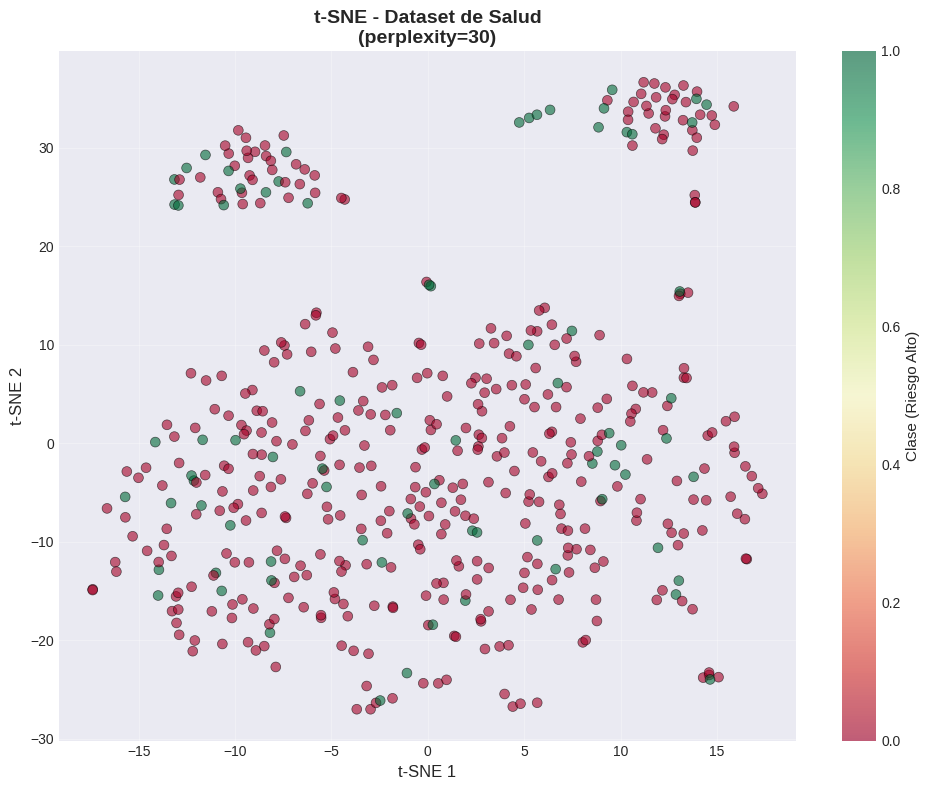

In [13]:
def apply_tsne_visualization(X, y=None, perplexity=30):
    """
    Aplica t-SNE para visualización 2D
    """
    print(f"Ejecutando t-SNE con perplexity={perplexity}...")

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42,
               n_iter=1000, verbose=0)
    X_tsne = tsne.fit_transform(X)

    print("✓ t-SNE completado")

    # Visualización
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    if y is not None:
        scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                           c=y, cmap='RdYlGn', alpha=0.6, s=50,
                           edgecolors='black', linewidth=0.5)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Clase (Riesgo Alto)', fontsize=11)
    else:
        ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                  alpha=0.6, s=50, color='steelblue',
                  edgecolors='black', linewidth=0.5)

    ax.set_xlabel('t-SNE 1', fontsize=12)
    ax.set_ylabel('t-SNE 2', fontsize=12)
    ax.set_title(f't-SNE - Dataset de Salud\n(perplexity={perplexity})',
                fontweight='bold', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()

    return X_tsne, fig

# Aplicar t-SNE
X_health_tsne, fig_tsne_health = apply_tsne_visualization(X_health_scaled, y_health, perplexity=30)
plt.show()

## 2.4 Comparación: PCA vs t-SNE

Comparemos cómo cada método visualiza la estructura del dataset.

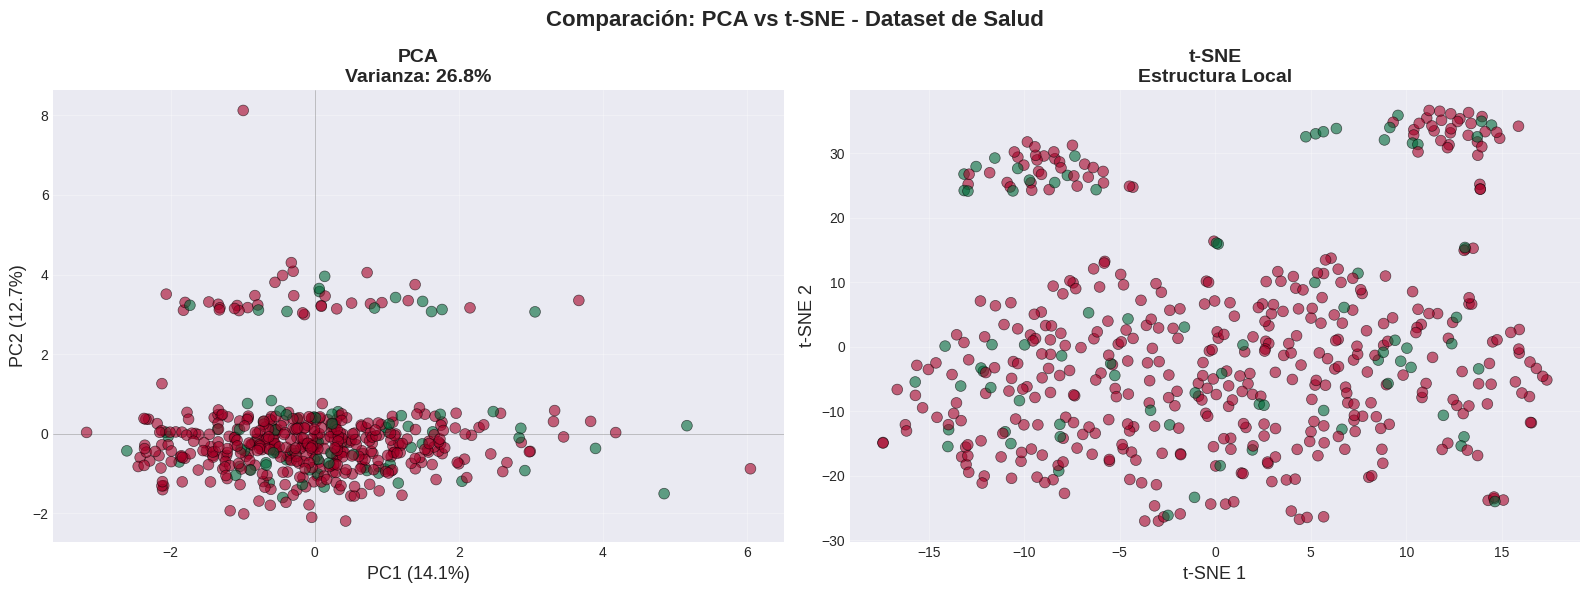


INTERPRETACIÓN

PCA:
  • Transformación lineal
  • Maximiza varianza
  • Ejes interpretables
  • Rápido y determinístico

t-SNE:
  • Transformación no lineal
  • Preserva vecindarios locales
  • Mejor para detectar clusters
  • Más lento, no determinístico



In [14]:
def compare_pca_tsne(X_pca, X_tsne, y, pca_variance):
    """
    Compara visualizaciones de PCA y t-SNE lado a lado
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # PCA
    ax = axes[0]
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1],
                        c=y, cmap='RdYlGn', alpha=0.6, s=60,
                        edgecolors='black', linewidth=0.5)
    ax.set_xlabel(f'PC1 ({pca_variance[0]:.1%})', fontsize=13)
    ax.set_ylabel(f'PC2 ({pca_variance[1]:.1%})', fontsize=13)
    ax.set_title(f'PCA\nVarianza: {pca_variance[0]+pca_variance[1]:.1%}',
                fontweight='bold', fontsize=14)
    ax.grid(alpha=0.3)
    ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)

    # t-SNE
    ax = axes[1]
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1],
                        c=y, cmap='RdYlGn', alpha=0.6, s=60,
                        edgecolors='black', linewidth=0.5)
    ax.set_xlabel('t-SNE 1', fontsize=13)
    ax.set_ylabel('t-SNE 2', fontsize=13)
    ax.set_title('t-SNE\nEstructura Local', fontweight='bold', fontsize=14)
    ax.grid(alpha=0.3)

    # Colorbar compartida
    #cbar = plt.colorbar(scatter, ax=axes, label='Riesgo Alto')

    plt.suptitle('Comparación: PCA vs t-SNE - Dataset de Salud',
                fontsize=16, fontweight='bold')
    plt.tight_layout()

    return fig

fig_comparison = compare_pca_tsne(
    X_health_pca,
    X_health_tsne,
    y_health,
    pca_health.explained_variance_ratio_
)
plt.show()

print("\n" + "="*80)
print("INTERPRETACIÓN")
print("="*80)
print("""
PCA:
  • Transformación lineal
  • Maximiza varianza
  • Ejes interpretables
  • Rápido y determinístico

t-SNE:
  • Transformación no lineal
  • Preserva vecindarios locales
  • Mejor para detectar clusters
  • Más lento, no determinístico
""")

---
# Parte 3: Selección de Atributos

Usaremos el dataset Wisconsin Breast Cancer para identificar las características más relevantes.

## 3.1 Preparación: Dataset Wisconsin Breast Cancer

Un dataset clásico con 30 características para clasificación binaria.

In [15]:
# Cargar dataset
cancer = load_breast_cancer()
X_cancer = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_cancer = cancer.target

print("="*80)
print("DATASET: Wisconsin Breast Cancer")
print("="*80)
print(f"\nDimensiones: {X_cancer.shape}")
print(f"\nClases: {np.unique(y_cancer, return_counts=True)}")
print(f"  0 (Maligno): {(y_cancer==0).sum()}")
print(f"  1 (Benigno): {(y_cancer==1).sum()}")
print(f"\nPrimeras 10 características:")
for i, col in enumerate(X_cancer.columns[:10], 1):
    print(f"  {i:2d}. {col}")
print("  ...")

# Escalamiento (necesario para métodos)
scaler_cancer = StandardScaler()
X_cancer_scaled = scaler_cancer.fit_transform(X_cancer)
X_cancer_scaled_df = pd.DataFrame(X_cancer_scaled, columns=X_cancer.columns)

print(f"\n✓ Datos escalados con StandardScaler")

DATASET: Wisconsin Breast Cancer

Dimensiones: (569, 30)

Clases: (array([0, 1]), array([212, 357]))
  0 (Maligno): 212
  1 (Benigno): 357

Primeras 10 características:
   1. mean radius
   2. mean texture
   3. mean perimeter
   4. mean area
   5. mean smoothness
   6. mean compactness
   7. mean concavity
   8. mean concave points
   9. mean symmetry
  10. mean fractal dimension
  ...

✓ Datos escalados con StandardScaler


## 3.2 Métodos Filter

Evalúan la relevancia de cada atributo independientemente del modelo.

MÉTODOS FILTER - SELECCIÓN DE ATRIBUTOS

1. Ejecutando ANOVA F-test... ✓
2. Ejecutando Mutual Information... ✓
3. Ejecutando Chi-squared... ✓

TOP 10 FEATURES POR MÉTODO

F-test:
             Feature   Score
worst concave points 964.385
     worst perimeter 897.944
 mean concave points 861.676
        worst radius 860.782
      mean perimeter 697.235
          worst area 661.600
         mean radius 646.981
           mean area 573.061
      mean concavity 533.793
     worst concavity 436.692

Mutual Info:
             Feature  Score
     worst perimeter  0.474
          worst area  0.464
        worst radius  0.453
 mean concave points  0.439
worst concave points  0.433
      mean perimeter  0.403
      mean concavity  0.374
         mean radius  0.366
           mean area  0.359
          area error  0.340

Chi-squared:
             Feature  Score
 mean concave points 52.406
worst concave points 46.342
      mean concavity 46.186
          worst area 35.044
     worst perimeter 34.43

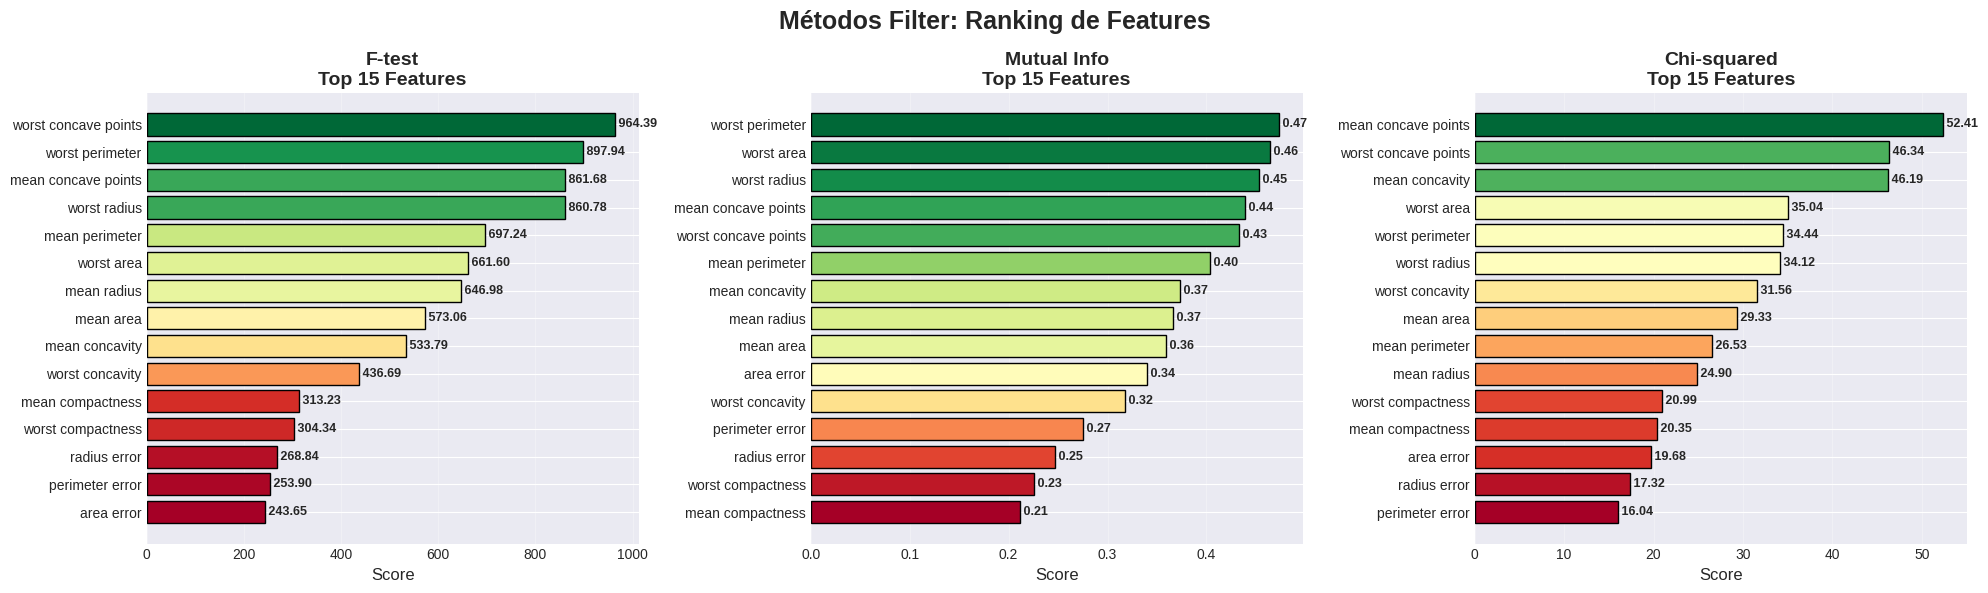

In [16]:
def apply_filter_methods(X, y, k=15):
    """
    Aplica múltiples métodos filter para selección de atributos
    """
    feature_names = X.columns if hasattr(X, 'columns') else [f'F{i}' for i in range(X.shape[1])]
    results = {}

    print("="*80)
    print("MÉTODOS FILTER - SELECCIÓN DE ATRIBUTOS")
    print("="*80)

    # 1. ANOVA F-test (para clasificación)
    print("\n1. Ejecutando ANOVA F-test...", end=' ')
    f_selector = SelectKBest(f_classif, k='all')
    f_selector.fit(X, y)
    results['F-test'] = pd.DataFrame({
        'Feature': feature_names,
        'Score': f_selector.scores_,
        'p-value': f_selector.pvalues_
    }).sort_values('Score', ascending=False)
    print("✓")

    # 2. Mutual Information
    print("2. Ejecutando Mutual Information...", end=' ')
    mi_selector = SelectKBest(mutual_info_classif, k='all')
    mi_selector.fit(X, y)
    results['Mutual Info'] = pd.DataFrame({
        'Feature': feature_names,
        'Score': mi_selector.scores_
    }).sort_values('Score', ascending=False)
    print("✓")

    # 3. Chi-squared (requiere valores no negativos)
    print("3. Ejecutando Chi-squared...", end=' ')
    # Normalizar a [0, 1] para chi2
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    chi2_selector = SelectKBest(chi2, k='all')
    chi2_selector.fit(X_normalized, y)
    results['Chi-squared'] = pd.DataFrame({
        'Feature': feature_names,
        'Score': chi2_selector.scores_
    }).sort_values('Score', ascending=False)
    print("✓")

    # Visualización
    fig = plt.figure(figsize=(20, 6))

    for idx, (method_name, scores_df) in enumerate(results.items(), 1):
        ax = plt.subplot(1, 3, idx)
        top_features = scores_df.head(k)

        # Colores basados en score normalizado
        scores_norm = (top_features['Score'] - top_features['Score'].min()) / (top_features['Score'].max() - top_features['Score'].min())
        colors = plt.cm.RdYlGn(scores_norm)

        bars = ax.barh(range(len(top_features)), top_features['Score'].values, color=colors, edgecolor='black')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['Feature'].values, fontsize=10)
        ax.invert_yaxis()
        ax.set_xlabel('Score', fontsize=12)
        ax.set_title(f'{method_name}\nTop {k} Features', fontweight='bold', fontsize=14)
        ax.grid(axis='x', alpha=0.3)

        # Añadir valores
        for i, (bar, score) in enumerate(zip(bars, top_features['Score'].values)):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f' {score:.2f}', ha='left', va='center', fontsize=9, fontweight='bold')

    plt.suptitle('Métodos Filter: Ranking de Features', fontsize=18, fontweight='bold')
    plt.tight_layout()

    # Imprimir rankings
    print("\n" + "="*80)
    print("TOP 10 FEATURES POR MÉTODO")
    print("="*80)
    for method_name, scores_df in results.items():
        print(f"\n{method_name}:")
        print(scores_df.head(10)[['Feature', 'Score']].to_string(index=False))

    return results, fig

# Aplicar métodos filter
filter_results, fig_filter = apply_filter_methods(
    pd.DataFrame(X_cancer_scaled, columns=X_cancer.columns),
    y_cancer,
    k=15
)
plt.show()

## 3.3 Métodos Wrapper (RFE)

Evalúan subconjuntos de features entrenando modelos.

MÉTODOS WRAPPER - RFE (Recursive Feature Elimination)

Seleccionando top 10 features con cada modelo...

Logistic Regression... ✓
  Features seleccionados: ['mean concave points', 'radius error', 'area error', 'compactness error', 'worst radius']...

Random Forest... ✓
  Features seleccionados: ['mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'worst radius']...

Gradient Boosting... ✓
  Features seleccionados: ['mean texture', 'mean concave points', 'area error', 'worst radius', 'worst texture']...


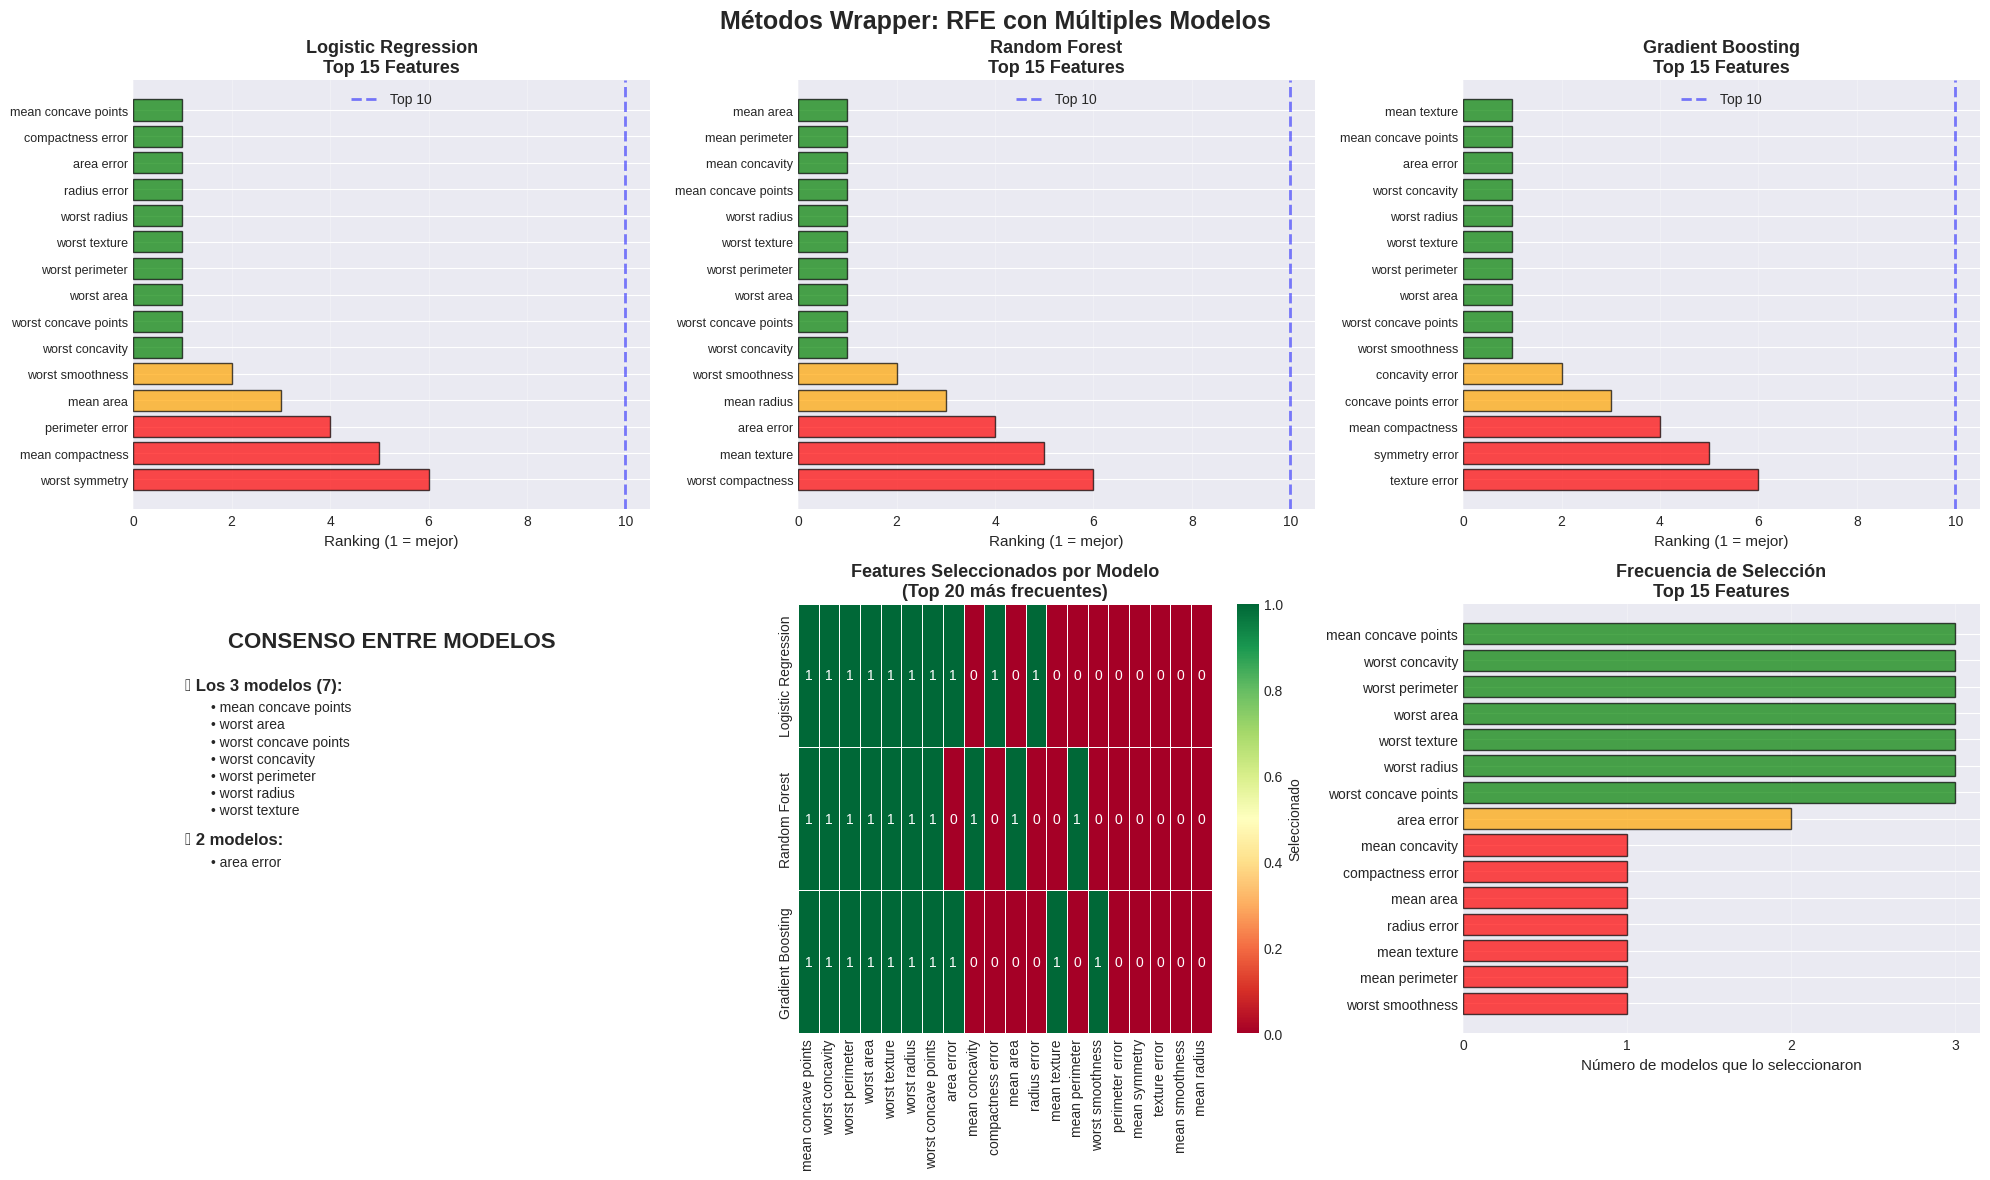


FEATURES CON CONSENSO (seleccionados por los 3 modelos):
  ✓ mean concave points
  ✓ worst area
  ✓ worst concave points
  ✓ worst concavity
  ✓ worst perimeter
  ✓ worst radius
  ✓ worst texture


In [17]:
def apply_wrapper_methods(X, y, n_features_to_select=10):
    """
    Aplica RFE (Recursive Feature Elimination) con diferentes modelos
    """
    feature_names = X.columns if hasattr(X, 'columns') else [f'F{i}' for i in range(X.shape[1])]

    # Definir modelos
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

    results = {}

    print("="*80)
    print("MÉTODOS WRAPPER - RFE (Recursive Feature Elimination)")
    print("="*80)
    print(f"\nSeleccionando top {n_features_to_select} features con cada modelo...")

    for model_name, model in models.items():
        print(f"\n{model_name}...", end=' ')

        # RFE
        rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=1)
        rfe.fit(X, y)

        # Guardar resultados
        results[model_name] = {
            'selected': feature_names[rfe.support_].tolist(),
            'ranking': rfe.ranking_
        }

        print("✓")
        print(f"  Features seleccionados: {results[model_name]['selected'][:5]}...")

    # Visualización
    fig = plt.figure(figsize=(20, 12))

    # 1. Ranking por modelo
    for idx, (model_name, result) in enumerate(results.items(), 1):
        ax = plt.subplot(2, 3, idx)

        ranking_df = pd.DataFrame({
            'Feature': feature_names,
            'Ranking': result['ranking']
        }).sort_values('Ranking')

        top_features = ranking_df.head(15)
        colors = ['green' if r == 1 else 'orange' if r <= 3 else 'red'
                 for r in top_features['Ranking']]

        bars = ax.barh(range(len(top_features)), top_features['Ranking'].values,
                      color=colors, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['Feature'].values, fontsize=9)
        ax.invert_yaxis()
        ax.set_xlabel('Ranking (1 = mejor)', fontsize=11)
        ax.set_title(f'{model_name}\nTop 15 Features', fontweight='bold', fontsize=13)
        ax.grid(axis='x', alpha=0.3)

        # Añadir línea en ranking = n_features_to_select
        ax.axvline(n_features_to_select, color='blue', linestyle='--',
                  linewidth=2, alpha=0.5, label=f'Top {n_features_to_select}')
        ax.legend()

    # 2. Diagrama de Venn (consenso)
    ax4 = plt.subplot(2, 3, 4)
    ax4.axis('off')

    selected_sets = {name: set(result['selected']) for name, result in results.items()}

    # Intersecciones
    all_three = selected_sets['Logistic Regression'] & selected_sets['Random Forest'] & selected_sets['Gradient Boosting']
    lr_rf = (selected_sets['Logistic Regression'] & selected_sets['Random Forest']) - all_three
    lr_gb = (selected_sets['Logistic Regression'] & selected_sets['Gradient Boosting']) - all_three
    rf_gb = (selected_sets['Random Forest'] & selected_sets['Gradient Boosting']) - all_three

    only_lr = selected_sets['Logistic Regression'] - selected_sets['Random Forest'] - selected_sets['Gradient Boosting']
    only_rf = selected_sets['Random Forest'] - selected_sets['Logistic Regression'] - selected_sets['Gradient Boosting']
    only_gb = selected_sets['Gradient Boosting'] - selected_sets['Logistic Regression'] - selected_sets['Random Forest']

    # Texto
    y_pos = 0.9
    ax4.text(0.5, y_pos, 'CONSENSO ENTRE MODELOS', ha='center', fontsize=16, fontweight='bold')
    y_pos -= 0.1

    ax4.text(0.1, y_pos, f'🟢 Los 3 modelos ({len(all_three)}):', fontsize=12, fontweight='bold')
    y_pos -= 0.05
    for feat in sorted(all_three):
        ax4.text(0.15, y_pos, f'• {feat}', fontsize=10)
        y_pos -= 0.04

    y_pos -= 0.03
    ax4.text(0.1, y_pos, f'🟡 2 modelos:', fontsize=12, fontweight='bold')
    y_pos -= 0.05
    for feat in sorted(lr_rf | lr_gb | rf_gb):
        ax4.text(0.15, y_pos, f'• {feat}', fontsize=10)
        y_pos -= 0.04
        if y_pos < 0.1:
            break

    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)

    # 3. Heatmap de selección
    ax5 = plt.subplot(2, 3, 5)
    selection_matrix = []
    model_names_list = list(results.keys())

    for model_name in model_names_list:
        row = [1 if feat in results[model_name]['selected'] else 0
               for feat in feature_names]
        selection_matrix.append(row)

    selection_df = pd.DataFrame(selection_matrix,
                               index=model_names_list,
                               columns=feature_names)

    # Ordenar por número de selecciones
    feature_counts = selection_df.sum(axis=0)
    selection_df = selection_df[feature_counts.sort_values(ascending=False).index]

    sns.heatmap(selection_df.iloc[:, :20], annot=True, fmt='d', cmap='RdYlGn',
                cbar_kws={'label': 'Seleccionado'}, ax=ax5,
                linewidths=0.5, vmin=0, vmax=1)
    ax5.set_title('Features Seleccionados por Modelo\n(Top 20 más frecuentes)',
                 fontweight='bold', fontsize=13)
    ax5.set_xlabel('')
    ax5.set_ylabel('')

    # 4. Frecuencia de selección
    ax6 = plt.subplot(2, 3, 6)
    feature_counts_sorted = feature_counts.sort_values(ascending=False).head(15)
    colors_freq = ['green' if c == 3 else 'orange' if c == 2 else 'red'
                   for c in feature_counts_sorted.values]

    bars = ax6.barh(range(len(feature_counts_sorted)), feature_counts_sorted.values,
                   color=colors_freq, alpha=0.7, edgecolor='black')
    ax6.set_yticks(range(len(feature_counts_sorted)))
    ax6.set_yticklabels(feature_counts_sorted.index, fontsize=10)
    ax6.invert_yaxis()
    ax6.set_xlabel('Número de modelos que lo seleccionaron', fontsize=11)
    ax6.set_title('Frecuencia de Selección\nTop 15 Features', fontweight='bold', fontsize=13)
    ax6.set_xticks([0, 1, 2, 3])
    ax6.grid(axis='x', alpha=0.3)

    plt.suptitle('Métodos Wrapper: RFE con Múltiples Modelos',
                fontsize=18, fontweight='bold')
    plt.tight_layout()

    return results, all_three, fig

# Aplicar RFE
wrapper_results, consensus_features, fig_wrapper = apply_wrapper_methods(
    pd.DataFrame(X_cancer_scaled, columns=X_cancer.columns),
    y_cancer,
    n_features_to_select=10
)
plt.show()

print("\n" + "="*80)
print("FEATURES CON CONSENSO (seleccionados por los 3 modelos):")
print("="*80)
for feat in sorted(consensus_features):
    print(f"  ✓ {feat}")

## 3.4 Visualización de Features Seleccionados

Usaremos PCA y t-SNE para comparar el dataset original vs. features seleccionados.

Calculando t-SNE para dataset completo...
Calculando t-SNE para features seleccionados...
✓ Visualizaciones completadas


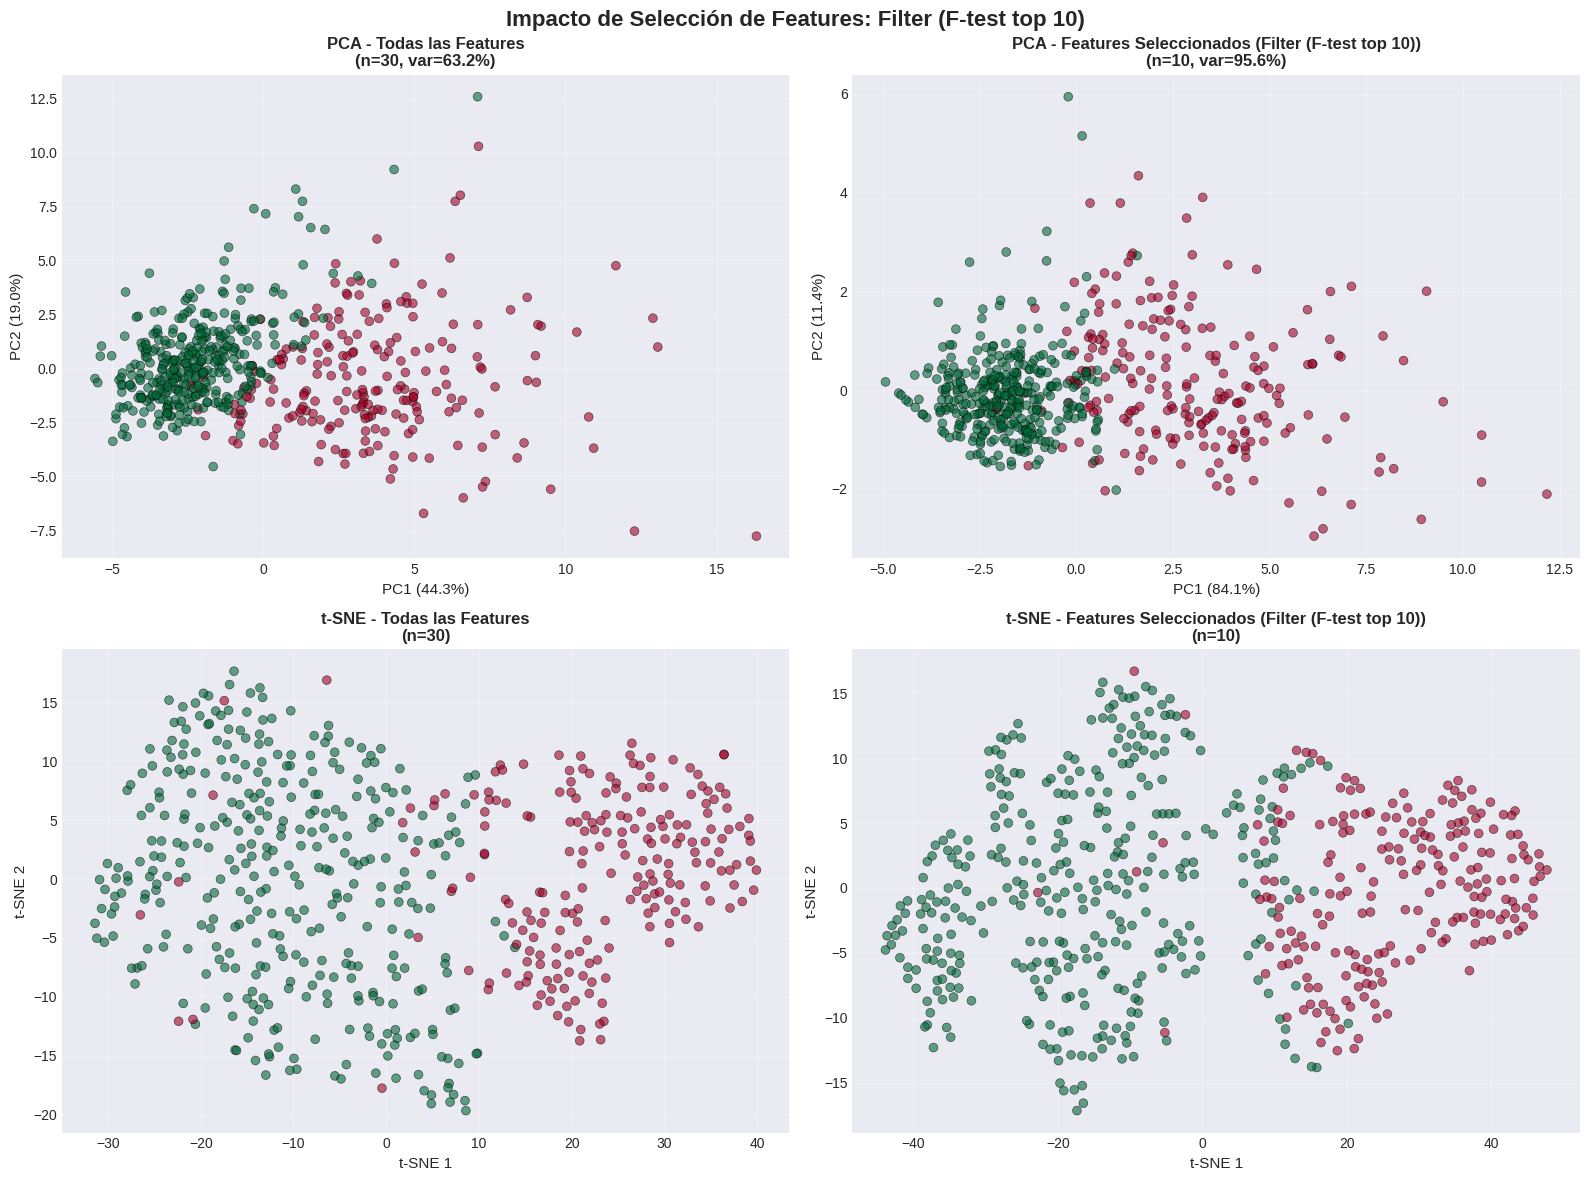

Calculando t-SNE para dataset completo...
Calculando t-SNE para features seleccionados...
✓ Visualizaciones completadas


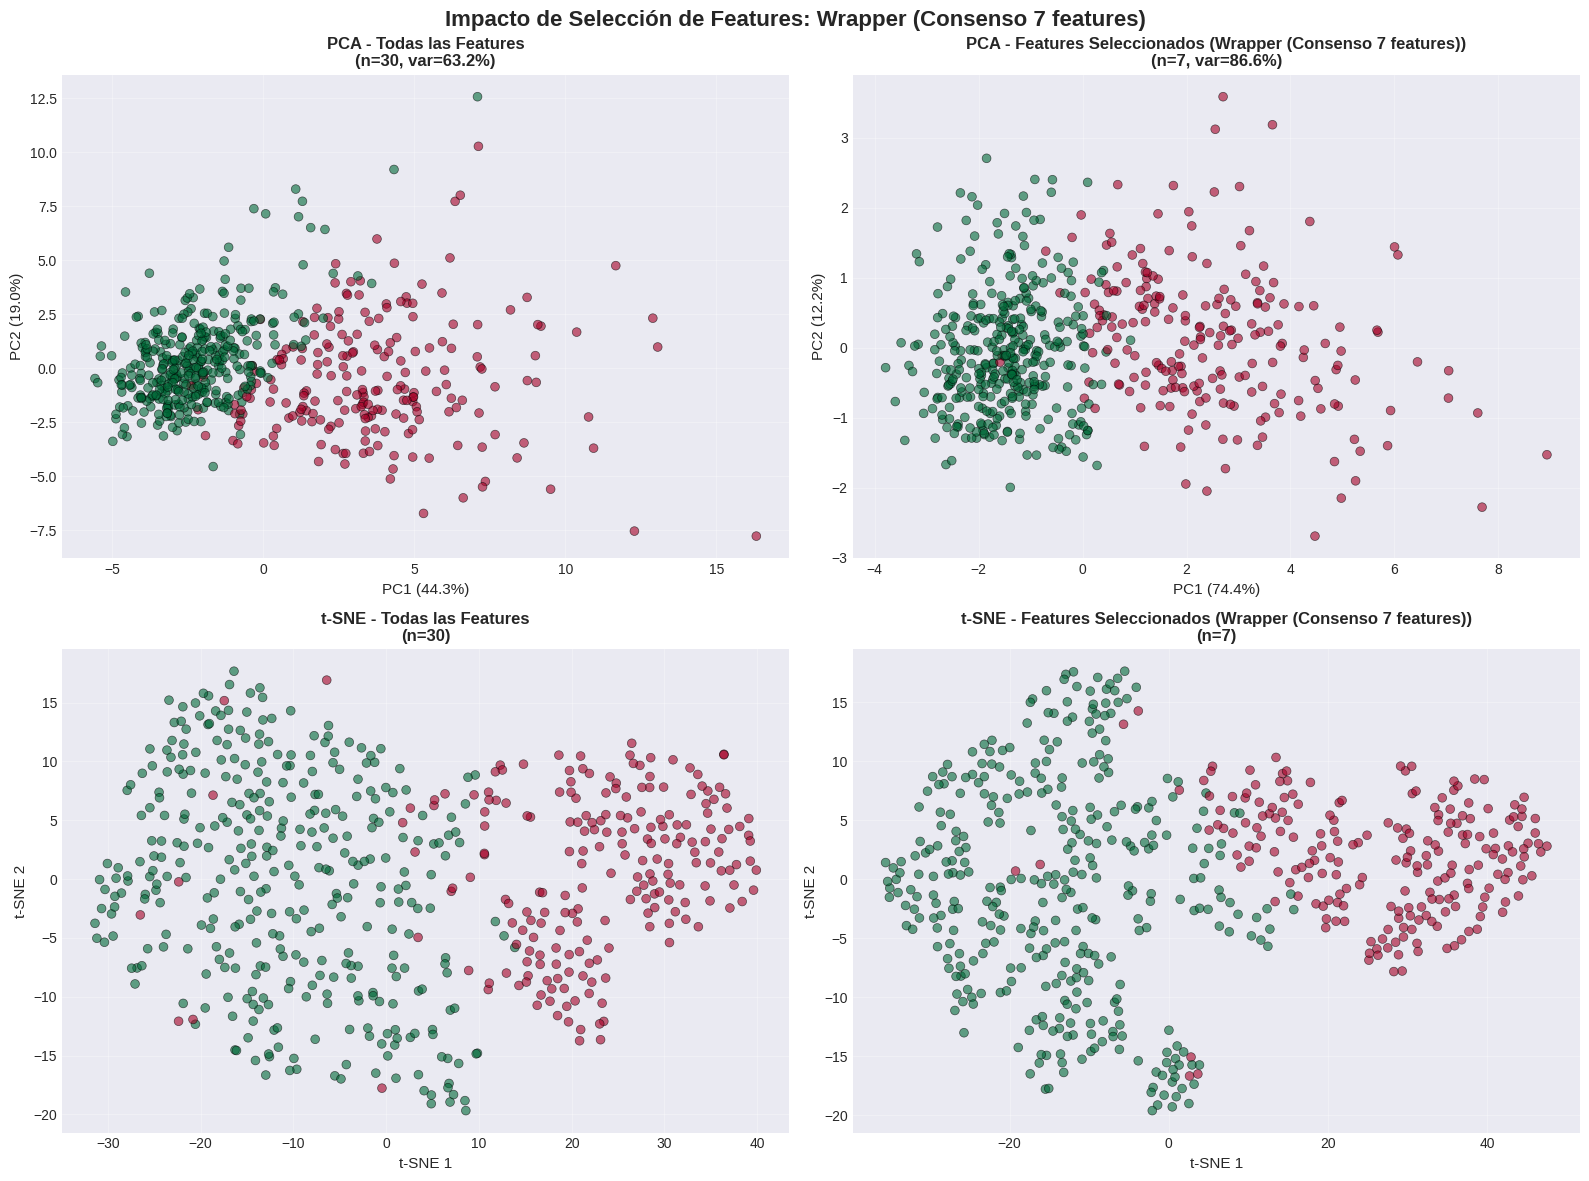


INTERPRETACIÓN

Features Originales: 30 dimensiones
Features Filter: 10 dimensiones
Features Wrapper: 7 dimensiones

Observaciones:
• La separación de clases se mantiene o mejora con menos features
• PCA muestra la varianza capturada en 2D
• t-SNE revela la estructura de clusters
• Menos features = modelos más simples y rápidos



In [18]:
def visualize_feature_selection_impact(X_full, X_selected, y, selected_names, method_name):
    """
    Compara visualización de dataset completo vs features seleccionados
    """
    # PCA en ambos
    pca_full = PCA(n_components=2)
    X_full_pca = pca_full.fit_transform(X_full)
    var_full = pca_full.explained_variance_ratio_

    pca_selected = PCA(n_components=2)
    X_selected_pca = pca_selected.fit_transform(X_selected)
    var_selected = pca_selected.explained_variance_ratio_

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # PCA - Dataset completo
    ax = axes[0, 0]
    scatter = ax.scatter(X_full_pca[:, 0], X_full_pca[:, 1],
                        c=y, cmap='RdYlGn', alpha=0.6, s=40,
                        edgecolors='black', linewidth=0.5)
    ax.set_xlabel(f'PC1 ({var_full[0]:.1%})', fontsize=11)
    ax.set_ylabel(f'PC2 ({var_full[1]:.1%})', fontsize=11)
    ax.set_title(f'PCA - Todas las Features\n(n={X_full.shape[1]}, var={var_full.sum():.1%})',
                fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)

    # PCA - Features seleccionados
    ax = axes[0, 1]
    scatter = ax.scatter(X_selected_pca[:, 0], X_selected_pca[:, 1],
                        c=y, cmap='RdYlGn', alpha=0.6, s=40,
                        edgecolors='black', linewidth=0.5)
    ax.set_xlabel(f'PC1 ({var_selected[0]:.1%})', fontsize=11)
    ax.set_ylabel(f'PC2 ({var_selected[1]:.1%})', fontsize=11)
    ax.set_title(f'PCA - Features Seleccionados ({method_name})\n(n={X_selected.shape[1]}, var={var_selected.sum():.1%})',
                fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)

    # t-SNE - Dataset completo
    print(f"Calculando t-SNE para dataset completo...")
    tsne_full = TSNE(n_components=2, perplexity=30, random_state=42, verbose=0)
    X_full_tsne = tsne_full.fit_transform(X_full)

    ax = axes[1, 0]
    scatter = ax.scatter(X_full_tsne[:, 0], X_full_tsne[:, 1],
                        c=y, cmap='RdYlGn', alpha=0.6, s=40,
                        edgecolors='black', linewidth=0.5)
    ax.set_xlabel('t-SNE 1', fontsize=11)
    ax.set_ylabel('t-SNE 2', fontsize=11)
    ax.set_title(f't-SNE - Todas las Features\n(n={X_full.shape[1]})',
                fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)

    # t-SNE - Features seleccionados
    print(f"Calculando t-SNE para features seleccionados...")
    tsne_selected = TSNE(n_components=2, perplexity=30, random_state=42, verbose=0)
    X_selected_tsne = tsne_selected.fit_transform(X_selected)

    ax = axes[1, 1]
    scatter = ax.scatter(X_selected_tsne[:, 0], X_selected_tsne[:, 1],
                        c=y, cmap='RdYlGn', alpha=0.6, s=40,
                        edgecolors='black', linewidth=0.5)
    ax.set_xlabel('t-SNE 1', fontsize=11)
    ax.set_ylabel('t-SNE 2', fontsize=11)
    ax.set_title(f't-SNE - Features Seleccionados ({method_name})\n(n={X_selected.shape[1]})',
                fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)

    # Colorbar
    #cbar = plt.colorbar(scatter, ax=axes, label='Clase (0=Maligno, 1=Benigno)')

    plt.suptitle(f'Impacto de Selección de Features: {method_name}',
                fontsize=16, fontweight='bold')
    plt.tight_layout()

    print("✓ Visualizaciones completadas")

    return fig

# Visualizar impacto de métodos Filter (top 10 por F-test)
top_10_filter = filter_results['F-test'].head(10)['Feature'].tolist()
X_cancer_filter = X_cancer_scaled_df[top_10_filter]

fig_filter_viz = visualize_feature_selection_impact(
    X_cancer_scaled,
    X_cancer_filter,
    y_cancer,
    top_10_filter,
    "Filter (F-test top 10)"
)
plt.show()

# Visualizar impacto de métodos Wrapper (consenso)
X_cancer_wrapper = X_cancer_scaled_df[list(consensus_features)]

fig_wrapper_viz = visualize_feature_selection_impact(
    X_cancer_scaled,
    X_cancer_wrapper,
    y_cancer,
    list(consensus_features),
    f"Wrapper (Consenso {len(consensus_features)} features)"
)
plt.show()

print("\n" + "="*80)
print("INTERPRETACIÓN")
print("="*80)
print(f"""
Features Originales: {X_cancer.shape[1]} dimensiones
Features Filter: {len(top_10_filter)} dimensiones
Features Wrapper: {len(consensus_features)} dimensiones

Observaciones:
• La separación de clases se mantiene o mejora con menos features
• PCA muestra la varianza capturada en 2D
• t-SNE revela la estructura de clusters
• Menos features = modelos más simples y rápidos
""")

---
# Parte 4: Balanceo de Clases

Trabajaremos con un dataset sintético desbalanceado para explorar diferentes técnicas de balanceo.

## 4.1 Creación de Dataset Desbalanceado

Simularemos un escenario realista de desbalance severo (90%-10%).

DATASET DESBALANCEADO CREADO

Total de observaciones: 1000
  Clase 0:  898 (89.80%)
  Clase 1:  102 (10.20%)

Ratio Minoría/Mayoría: 0.114


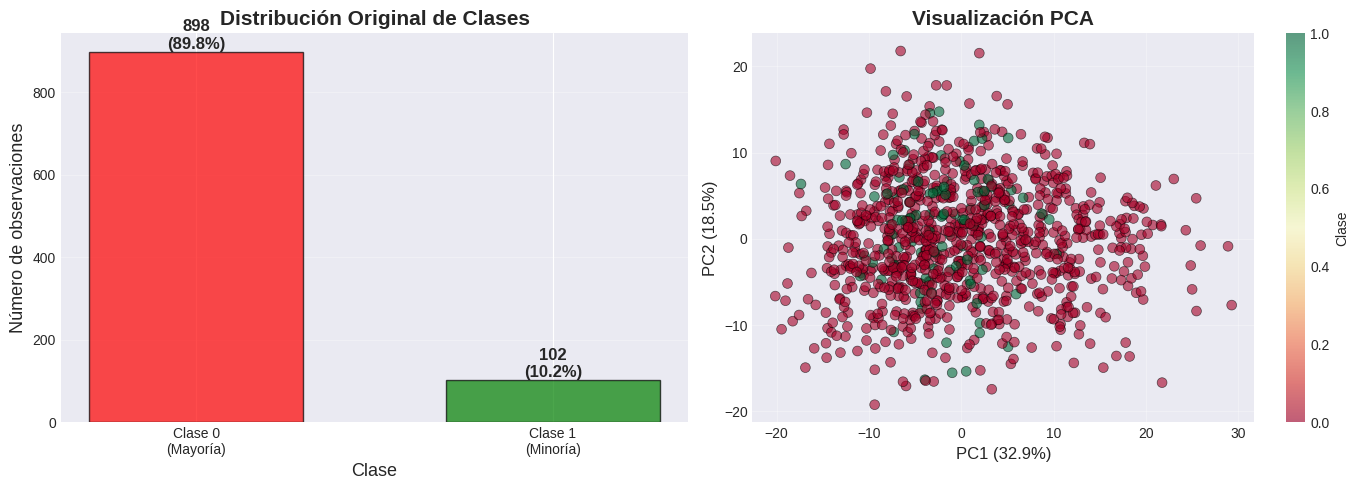

In [19]:
# Crear dataset desbalanceado
def create_imbalanced_dataset(n_samples=1000, imbalance_ratio=0.1):
    """
    Crea dataset de clasificación con desbalance de clases
    """
    X_imb, y_imb = make_classification(
        n_samples=n_samples,
        n_features=20,
        n_informative=15,
        n_redundant=5,
        n_classes=2,
        weights=[1-imbalance_ratio, imbalance_ratio],
        flip_y=0.01,
        random_state=42
    )

    print("="*80)
    print("DATASET DESBALANCEADO CREADO")
    print("="*80)
    print(f"\nTotal de observaciones: {len(y_imb)}")
    unique, counts = np.unique(y_imb, return_counts=True)
    for cls, count in zip(unique, counts):
        pct = 100 * count / len(y_imb)
        print(f"  Clase {cls}: {count:4d} ({pct:5.2f}%)")

    ratio = counts[1] / counts[0]
    print(f"\nRatio Minoría/Mayoría: {ratio:.3f}")

    return X_imb, y_imb

# Crear dataset
X_imb, y_imb = create_imbalanced_dataset(n_samples=1000, imbalance_ratio=0.10)

# Visualizar distribución original
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de clases
ax = axes[0]
unique, counts = np.unique(y_imb, return_counts=True)
bars = ax.bar(unique, counts, color=['red', 'green'], alpha=0.7, edgecolor='black', width=0.6)
ax.set_xlabel('Clase', fontsize=13)
ax.set_ylabel('Número de observaciones', fontsize=13)
ax.set_title('Distribución Original de Clases', fontweight='bold', fontsize=15)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Clase 0\n(Mayoría)', 'Clase 1\n(Minoría)'])
ax.grid(axis='y', alpha=0.3)

for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{count}\n({100*count/len(y_imb):.1f}%)',
           ha='center', va='bottom', fontsize=12, fontweight='bold')

# PCA
ax = axes[1]
pca_imb = PCA(n_components=2)
X_imb_pca = pca_imb.fit_transform(X_imb)
scatter = ax.scatter(X_imb_pca[:, 0], X_imb_pca[:, 1],
                    c=y_imb, cmap='RdYlGn', alpha=0.6, s=50,
                    edgecolors='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_imb.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_imb.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_title('Visualización PCA', fontweight='bold', fontsize=15)
ax.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Clase')

plt.tight_layout()
plt.show()

## 4.2 Técnicas de Oversampling

Generaremos ejemplos sintéticos de la clase minoritaria.

### 4.2.1 Random Oversampling

Duplica aleatoriamente ejemplos existentes de la clase minoritaria.

RANDOM OVERSAMPLING

Antes: 1000 observaciones
Después: 1796 observaciones (+796)

Distribución:
  Clase 0:  898 (50.0%)
  Clase 1:  898 (50.0%)


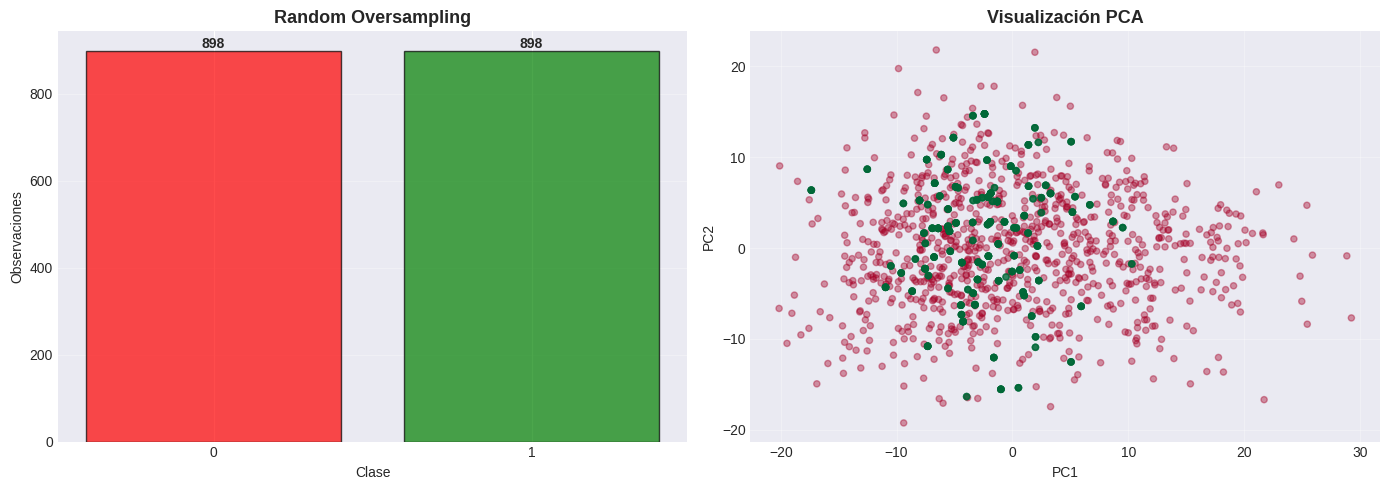


💡 Duplica ejemplos existentes → riesgo de overfitting


In [20]:
# Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_imb, y_imb)

print("="*80)
print("RANDOM OVERSAMPLING")
print("="*80)
print(f"\nAntes: {len(y_imb)} observaciones")
print(f"Después: {len(y_ros)} observaciones (+{len(y_ros)-len(y_imb)})")
print(f"\nDistribución:")
unique, counts = np.unique(y_ros, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Clase {cls}: {count:4d} ({100*count/len(y_ros):.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
bars = ax.bar(unique, counts, color=['red', 'green'], alpha=0.7, edgecolor='black')
ax.set_xlabel('Clase')
ax.set_ylabel('Observaciones')
ax.set_title('Random Oversampling', fontweight='bold', fontsize=13)
ax.set_xticks([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
           f'{count}', ha='center', va='bottom', fontweight='bold')

ax = axes[1]
X_ros_pca = pca_imb.transform(X_ros)
scatter = ax.scatter(X_ros_pca[:, 0], X_ros_pca[:, 1],
                    c=y_ros, cmap='RdYlGn', alpha=0.4, s=20)
ax.set_xlabel(f'PC1')
ax.set_ylabel(f'PC2')
ax.set_title('Visualización PCA', fontweight='bold', fontsize=13)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("\n💡 Duplica ejemplos existentes → riesgo de overfitting")

### 4.2.2 SMOTE (Synthetic Minority Over-sampling Technique)

Genera ejemplos sintéticos interpolando entre vecinos cercanos.

SMOTE

Antes: 1000 observaciones
Después: 1796 observaciones (+796)

Distribución:
  Clase 0:  898 (50.0%)
  Clase 1:  898 (50.0%)


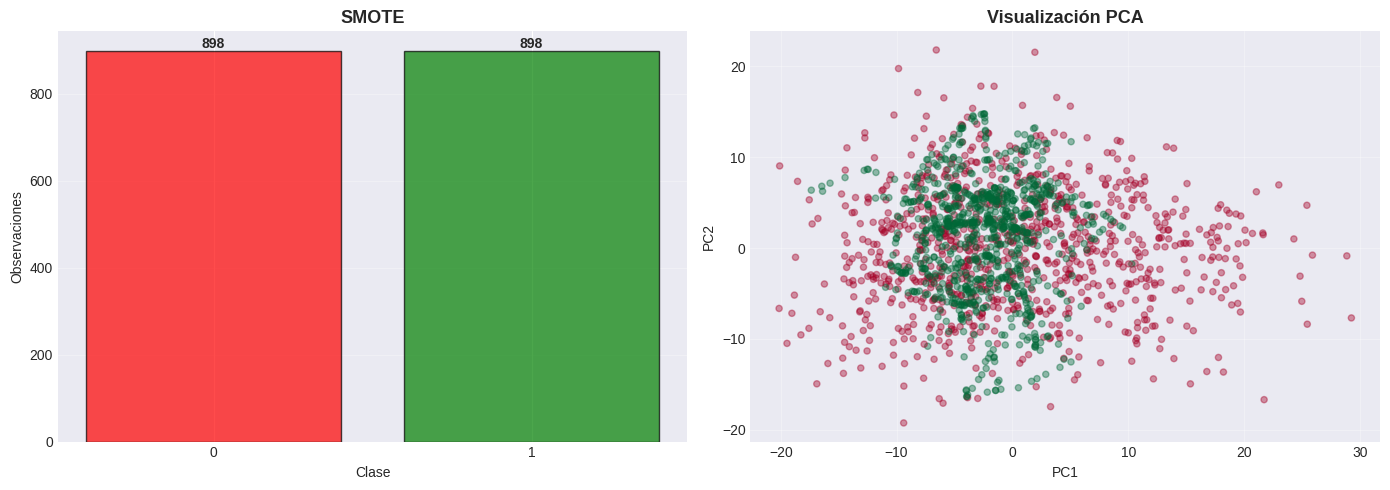


💡 Crea ejemplos sintéticos interpolando → más robusto que duplicar


In [21]:
# SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_imb, y_imb)

print("="*80)
print("SMOTE")
print("="*80)
print(f"\nAntes: {len(y_imb)} observaciones")
print(f"Después: {len(y_smote)} observaciones (+{len(y_smote)-len(y_imb)})")
print(f"\nDistribución:")
unique, counts = np.unique(y_smote, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Clase {cls}: {count:4d} ({100*count/len(y_smote):.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
bars = ax.bar(unique, counts, color=['red', 'green'], alpha=0.7, edgecolor='black')
ax.set_xlabel('Clase')
ax.set_ylabel('Observaciones')
ax.set_title('SMOTE', fontweight='bold', fontsize=13)
ax.set_xticks([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
           f'{count}', ha='center', va='bottom', fontweight='bold')

ax = axes[1]
X_smote_pca = pca_imb.transform(X_smote)
scatter = ax.scatter(X_smote_pca[:, 0], X_smote_pca[:, 1],
                    c=y_smote, cmap='RdYlGn', alpha=0.4, s=20)
ax.set_xlabel(f'PC1')
ax.set_ylabel(f'PC2')
ax.set_title('Visualización PCA', fontweight='bold', fontsize=13)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("\n💡 Crea ejemplos sintéticos interpolando → más robusto que duplicar")

### 4.2.3 ADASYN (Adaptive Synthetic Sampling)

Adapta la generación según la densidad local (más ejemplos en regiones difíciles).

ADASYN

Antes: 1000 observaciones
Después: 1788 observaciones (+788)

Distribución:
  Clase 0:  898 (50.2%)
  Clase 1:  890 (49.8%)


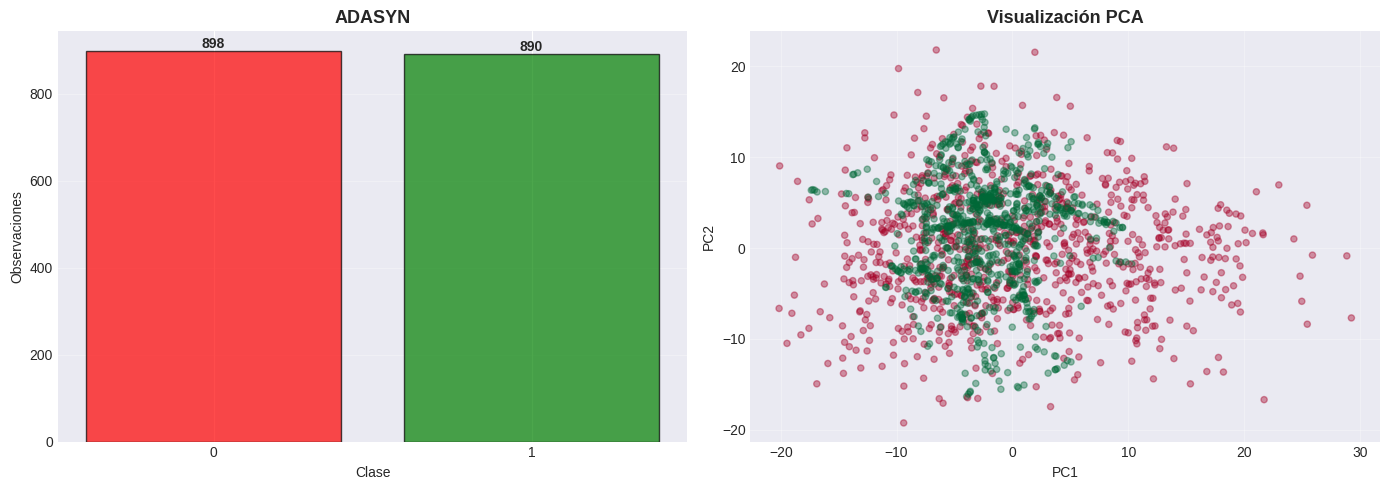


💡 Genera más ejemplos en regiones difíciles → adaptativo


In [22]:
# ADASYN
try:
    adasyn = ADASYN(random_state=42, n_neighbors=5)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_imb, y_imb)

    print("="*80)
    print("ADASYN")
    print("="*80)
    print(f"\nAntes: {len(y_imb)} observaciones")
    print(f"Después: {len(y_adasyn)} observaciones (+{len(y_adasyn)-len(y_imb)})")
    print(f"\nDistribución:")
    unique, counts = np.unique(y_adasyn, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  Clase {cls}: {count:4d} ({100*count/len(y_adasyn):.1f}%)")

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    bars = ax.bar(unique, counts, color=['red', 'green'], alpha=0.7, edgecolor='black')
    ax.set_xlabel('Clase')
    ax.set_ylabel('Observaciones')
    ax.set_title('ADASYN', fontweight='bold', fontsize=13)
    ax.set_xticks([0, 1])
    ax.grid(axis='y', alpha=0.3)
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
               f'{count}', ha='center', va='bottom', fontweight='bold')

    ax = axes[1]
    X_adasyn_pca = pca_imb.transform(X_adasyn)
    scatter = ax.scatter(X_adasyn_pca[:, 0], X_adasyn_pca[:, 1],
                        c=y_adasyn, cmap='RdYlGn', alpha=0.4, s=20)
    ax.set_xlabel(f'PC1')
    ax.set_ylabel(f'PC2')
    ax.set_title('Visualización PCA', fontweight='bold', fontsize=13)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
    print("\n💡 Genera más ejemplos en regiones difíciles → adaptativo")
    adasyn_ok = True
except:
    print("⚠️  ADASYN no aplicable (muy pocos ejemplos minoritarios)")
    adasyn_ok = False

## 4.3 Técnicas de Undersampling

Reducimos ejemplos de la clase mayoritaria.

RANDOM UNDERSAMPLING

Antes: 1000 observaciones
Después: 204 observaciones (-796)

Distribución:
  Clase 0:  102 (50.0%)
  Clase 1:  102 (50.0%)


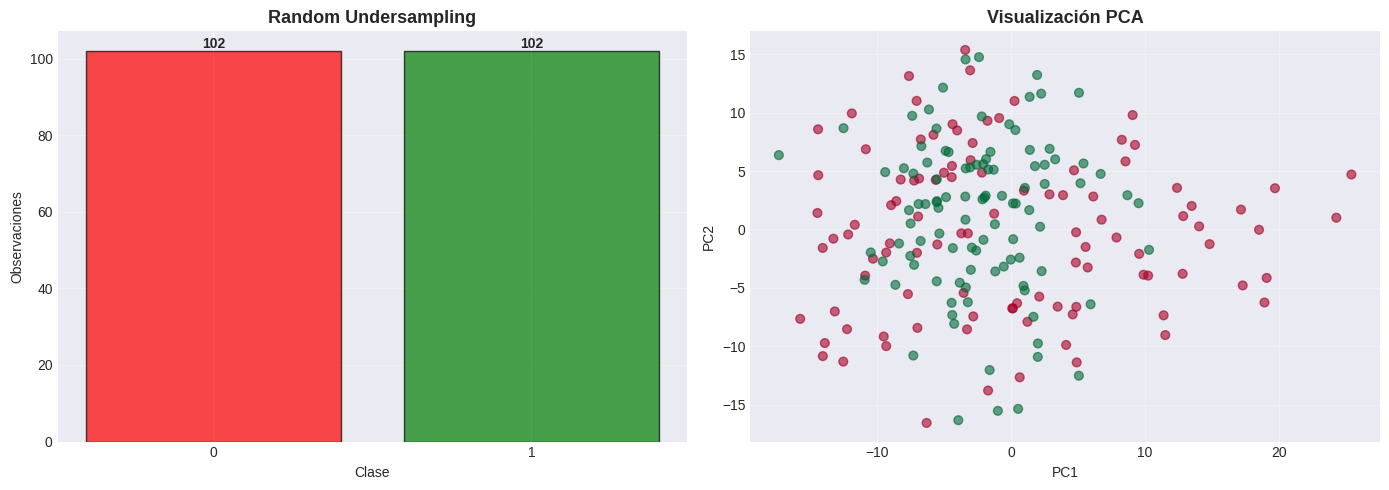


💡 Elimina ejemplos de la mayoría → puede perder información útil


In [23]:
# Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_imb, y_imb)

print("="*80)
print("RANDOM UNDERSAMPLING")
print("="*80)
print(f"\nAntes: {len(y_imb)} observaciones")
print(f"Después: {len(y_rus)} observaciones ({len(y_rus)-len(y_imb)})")
print(f"\nDistribución:")
unique, counts = np.unique(y_rus, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Clase {cls}: {count:4d} ({100*count/len(y_rus):.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
bars = ax.bar(unique, counts, color=['red', 'green'], alpha=0.7, edgecolor='black')
ax.set_xlabel('Clase')
ax.set_ylabel('Observaciones')
ax.set_title('Random Undersampling', fontweight='bold', fontsize=13)
ax.set_xticks([0, 1])
ax.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
           f'{count}', ha='center', va='bottom', fontweight='bold')

ax = axes[1]
X_rus_pca = pca_imb.transform(X_rus)
scatter = ax.scatter(X_rus_pca[:, 0], X_rus_pca[:, 1],
                    c=y_rus, cmap='RdYlGn', alpha=0.6, s=40)
ax.set_xlabel(f'PC1')
ax.set_ylabel(f'PC2')
ax.set_title('Visualización PCA', fontweight='bold', fontsize=13)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()
print("\n💡 Elimina ejemplos de la mayoría → puede perder información útil")

## 4.4 Comparación Visual de Métodos

Veamos todos los métodos juntos en el espacio PCA.

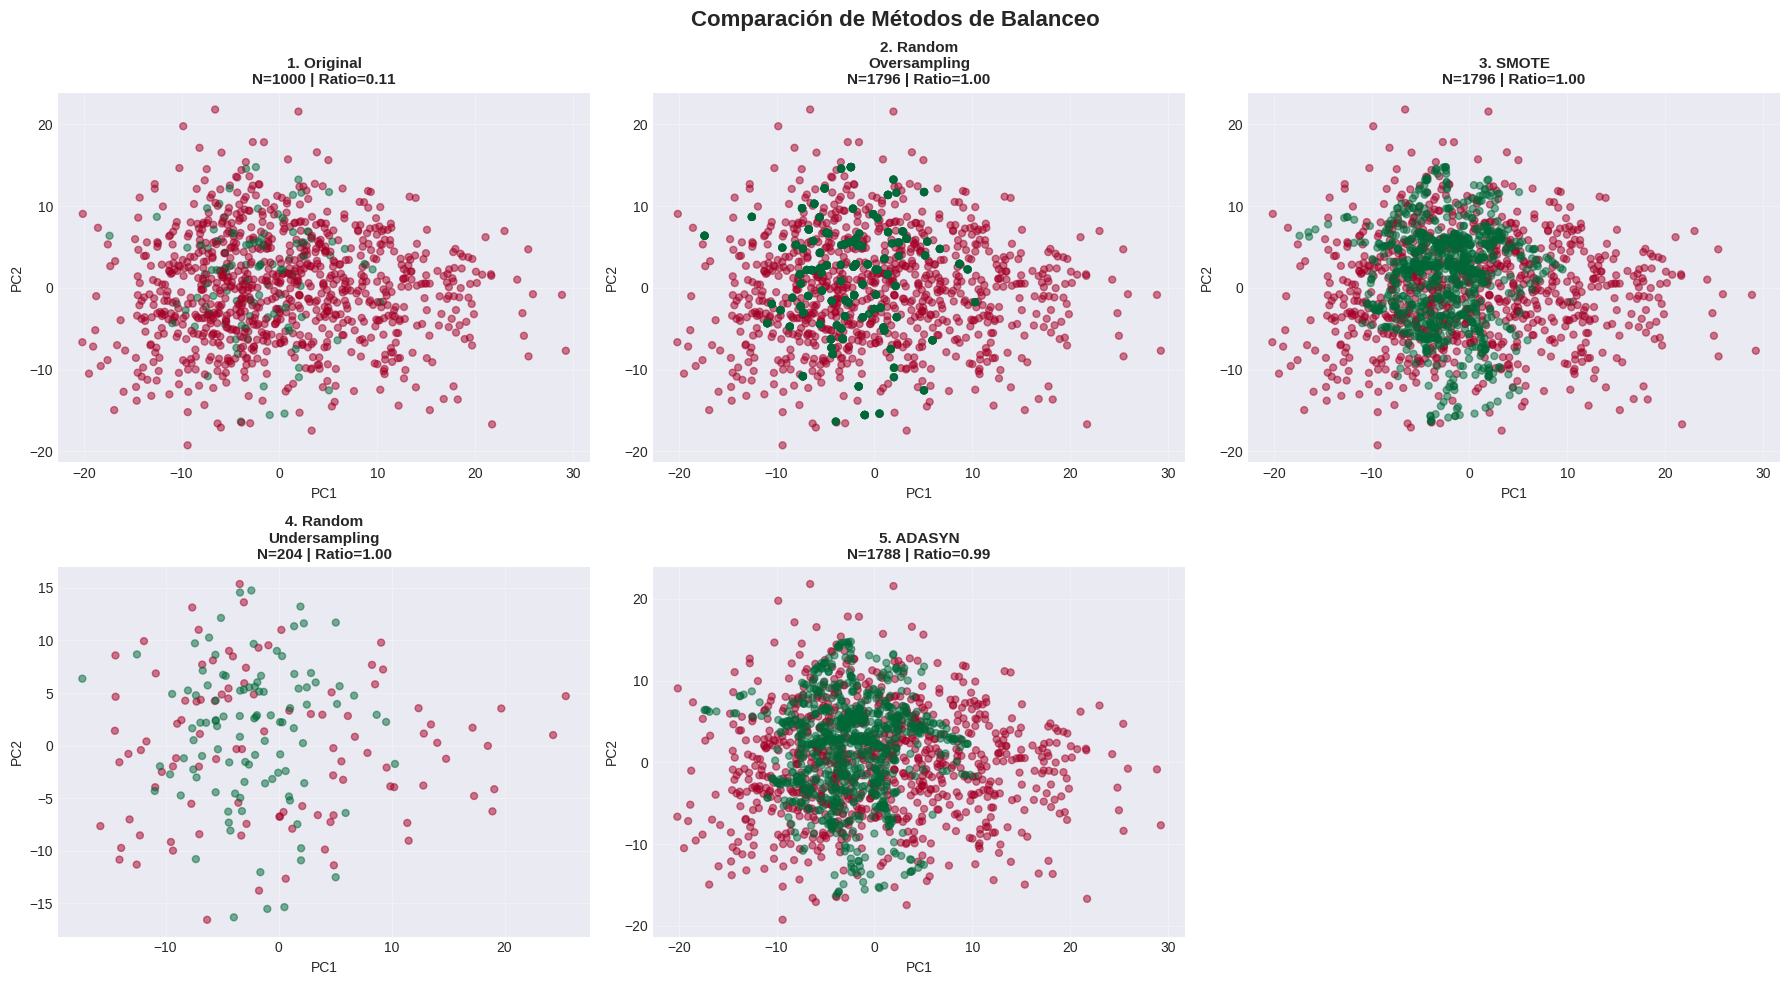

In [24]:
# Comparación
methods = {
    '1. Original': (X_imb, y_imb),
    '2. Random\nOversampling': (X_ros, y_ros),
    '3. SMOTE': (X_smote, y_smote),
    '4. Random\nUndersampling': (X_rus, y_rus)
}

if adasyn_ok:
    methods['5. ADASYN'] = (X_adasyn, y_adasyn)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (name, (X_bal, y_bal)) in enumerate(methods.items()):
    if idx >= len(axes):
        break

    ax = axes[idx]
    X_bal_pca = pca_imb.transform(X_bal)

    scatter = ax.scatter(X_bal_pca[:, 0], X_bal_pca[:, 1],
                        c=y_bal, cmap='RdYlGn', alpha=0.5, s=25)

    unique, counts = np.unique(y_bal, return_counts=True)
    ratio = counts[1]/counts[0] if len(counts)>1 else 0

    ax.set_xlabel('PC1', fontsize=10)
    ax.set_ylabel('PC2', fontsize=10)
    ax.set_title(f'{name}\nN={len(y_bal)} | Ratio={ratio:.2f}',
                fontweight='bold', fontsize=11)
    ax.grid(alpha=0.3)

for idx in range(len(methods), len(axes)):
    axes[idx].axis('off')

#plt.colorbar(scatter, ax=axes, label='Clase')
plt.suptitle('Comparación de Métodos de Balanceo', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 4.5 Resumen y Recomendaciones

In [25]:
print("="*80)
print("RESUMEN DE TÉCNICAS DE BALANCEO")
print("="*80)

print("""
1️⃣ OVERSAMPLING (aumenta ejemplos minoritarios):
  • Random Oversampling:
    - Duplica ejemplos existentes
    - Riesgo: Overfitting
    - Uso: Dataset pequeño, evaluar baseline

  • SMOTE:
    - Crea ejemplos sintéticos (interpola k-vecinos)
    - Más robusto que duplicar
    - Uso: Recomendado en general

  • ADASYN:
    - Adapta síntesis a densidad local
    - Más ejemplos en regiones difíciles
    - Uso: Fronteras complejas

2️⃣ UNDERSAMPLING (reduce ejemplos mayoritarios):
  • Random Undersampling:
    - Elimina ejemplos de la mayoría aleatoriamente
    - Riesgo: Perder información útil
    - Ventaja: Datasets más pequeños = más rápido
    - Uso: Muchos datos disponibles

3️⃣ RECOMENDACIONES:
  1. Probar primero SMOTE (generalmente la mejor opción)
  2. Si muchos datos → Undersampling
  3. Si desbalance extremo → Combinar ambos
  4. Siempre evaluar con validación cruzada
  5. El mejor método depende del problema específico

⚠️  IMPORTANTE:
  • Aplicar balanceo SOLO en training set
  • Mantener test set sin modificar
  • Evaluar en datos reales del problema
""")

RESUMEN DE TÉCNICAS DE BALANCEO

1️⃣ OVERSAMPLING (aumenta ejemplos minoritarios):
  • Random Oversampling:
    - Duplica ejemplos existentes
    - Riesgo: Overfitting
    - Uso: Dataset pequeño, evaluar baseline

  • SMOTE:
    - Crea ejemplos sintéticos (interpola k-vecinos)
    - Más robusto que duplicar
    - Uso: Recomendado en general

  • ADASYN:
    - Adapta síntesis a densidad local
    - Más ejemplos en regiones difíciles
    - Uso: Fronteras complejas

2️⃣ UNDERSAMPLING (reduce ejemplos mayoritarios):
  • Random Undersampling:
    - Elimina ejemplos de la mayoría aleatoriamente
    - Riesgo: Perder información útil
    - Ventaja: Datasets más pequeños = más rápido
    - Uso: Muchos datos disponibles

3️⃣ RECOMENDACIONES:
  1. Probar primero SMOTE (generalmente la mejor opción)
  2. Si muchos datos → Undersampling
  3. Si desbalance extremo → Combinar ambos
  4. Siempre evaluar con validación cruzada
  5. El mejor método depende del problema específico

⚠️  IMPORTANTE:
  • Ap

---
## 🎯 Ejercicio Final Integrador

Pon a prueba tu comprensión:

### Ejercicio 1: Dataset Diferente
Aplica las técnicas de limpieza a otro dataset:
* Wine Quality
* Iris
* Digits

### Ejercicio 2: Parámetros
Experimenta cambiando:
* Número de vecinos en KNN Imputer
* Percentiles para detección de outliers
* Número de componentes en PCA
* Perplexity en t-SNE

### Ejercicio 3: Análisis Comparativo
Compara:
* Diferentes estrategias de imputación en el mismo dataset
* PCA vs selección de features para reducción de dimensionalidad
* Diferentes métodos de balanceo en métricas específicas

### Ejercicio 4: Crear Dataset Propio
Genera un dataset sintético con:
* Patrones específicos de valores faltantes
* Outliers controlados
* Desbalance definido

In [26]:
# TU ANÁLISIS COMPLETO AQUÍ



---
## 📚 Resumen de la Sesión

### Lo que hemos aprendido

1. **Limpieza de Datos**
  - Los valores faltantes requieren análisis cuidadoso (MCAR, MAR, MNAR)
  - KNN Imputation generalmente supera a métodos simples
  - Los outliers deben investigarse antes de eliminarlos
  - El escalamiento es crucial para muchos algoritmos

2. **Reducción de Dimensionalidad**
  - **PCA**: Rápido, interpretable, lineal
  - **t-SNE**: Lento, no interpretable, no lineal

3. Selección de Atributos
  - **Métodos Filter**: Rápidos pero independientes del modelo
  - **Métodos Wrapper**: Más lentos pero específicos del modelo
  - **Consenso**: Combinar múltiples métodos aumenta robustez

4. Balanceo de Clases
  - El desbalance severo sesga modelos hacia la mayoría
  - **SMOTE** genera ejemplos sintéticos interpolando
  - **ADASYN** adapta la síntesis a la densidad local
  - **BorderlineSMOTE** enfoca en ejemplos frontera
  - **Random Oversampling** duplica ejemplos minoritarios

### Resultados Clave:

- El escalamiento normalizó las escalas entre variables
- PCA redujo dimensiones preservando estructura
- Los métodos Filter y Wrapper identificaron features consistentes
- SMOTE y variantes mejoraron la representación de clase minoritaria

### Próximos Pasos

- Esquemas de Partición y Validación
- Evaluación de modelos de Regresión
- Evaluación de modelos de Clasificación
- Comparación de Modelos y Mejores Prácticas

---

### 📖 Referencias y Recursos

* Scikit-learn Documentation: https://scikit-learn.org
* Imbalanced-learn: https://imbalanced-learn.org
* "Feature Engineering and Selection" - Kuhn & Johnson
* "Hands-On Machine Learning" - Aurélien Géron

---

**¿Preguntas? ¿Comentarios?**

Dr. Irvin Hussein López Nava  
CICESE - UABC